<a href="https://colab.research.google.com/github/wilmerwasv/Challenge-Telecom-X-an-lisis-de-evasi-n-de-clientes---Parte-2-_-wilmer-subero/blob/main/Challenge_Telecom_X_an%C3%A1lisis_de_evasi%C3%B3n_de_clientes_Parte_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [84]:
"""
OBJETIVO DEL PROYECTO:
Construir modelos predictivos para anticipar la cancelación de clientes (churn)
utilizando análisis estadístico y técnicas de Machine Learning.

PASOS DEL PROYECTO:
1. Preparación del entorno y carga de datos
2. Análisis exploratorio adicional
3. Preparación de datos para ML
4. Análisis de correlaciones
5. Construcción de modelos predictivos
6. Evaluación y métricas
7. Conclusiones estratégicas
"""

# ==========================================
# 1. IMPORTACIÓN DE LIBRERÍAS
# ==========================================

# Manipulación de datos
import pandas as pd
import numpy as np

# Visualización
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)

# Análisis estadístico
from scipy import stats
from scipy.stats import chi2_contingency

# Configuración de warnings
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Todas las librerías importadas correctamente")
print("Iniciando Telecom X Challenge Parte 2")

# ==========================================
# 2. CARGA Y EXPLORACIÓN INICIAL DE DATOS
# ==========================================

def cargar_datos(ruta_archivo=None):
    """
    Carga los datos tratados del challenge anterior

    Args:
        ruta_archivo (str): Ruta al archivo CSV tratado

    Returns:
        pd.DataFrame: DataFrame con los datos cargados
    """
    try:
        if ruta_archivo:
            df = pd.read_csv(ruta_archivo)
        else:
            df = pd.read_csv('datos_procesados.csv')

        print(f"Datos cargados exitosamente")
        print(f"Dimensiones: {df.shape[0]} filas, {df.shape[1]} columnas")

        # Mostrar información específica del dataset Telecom
        print(f"\nColumnas del dataset:")
        for i, col in enumerate(df.columns, 1):
            print(f"  {i:2d}. {col}")

        return df
    except Exception as e:
        print(f"Error al cargar los datos: {e}")
        return None

def exploracion_inicial(df):
    """
    Realiza una exploración inicial de los datos

    Args:
        df (pd.DataFrame): DataFrame a explorar
    """
    print("=" * 50)
    print("EXPLORACIÓN INICIAL DE DATOS")
    print("=" * 50)

    # Información básica
    print("\nInformación básica del dataset:")
    print(f"Filas: {df.shape[0]}")
    print(f"Columnas: {df.shape[1]}")

    # Tipos de datos
    print("\nTipos de datos:")
    print(df.dtypes.value_counts())

    # Valores nulos
    print("\nValores nulos por columna:")
    nulos = df.isnull().sum()
    if nulos.sum() > 0:
        print(nulos[nulos > 0])
    else:
        print("No hay valores nulos en el dataset")

    # Primeras filas
    print("\nPrimeras 5 filas:")
    print(df.head())

    return df

# ==========================================
# 3. ANÁLISIS DE LA VARIABLE OBJETIVO (CHURN)
# ==========================================

def analizar_churn(df, columna_churn='Churn'):
    """
    Analiza la distribución de la variable objetivo (churn)

    Args:
        df (pd.DataFrame): DataFrame con los datos
        columna_churn (str): Nombre de la columna de churn
    """
    print("=" * 50)
    print("ANÁLISIS DE LA VARIABLE OBJETIVO (CHURN)")
    print("=" * 50)

    if columna_churn not in df.columns:
        print(f"La columna '{columna_churn}' no existe en el dataset")
        print("Columnas disponibles:", list(df.columns))
        return

    # Distribución de churn
    churn_counts = df[columna_churn].value_counts()
    churn_props = df[columna_churn].value_counts(normalize=True) * 100

    print(f"\nDistribución de {columna_churn}:")
    for valor, count, prop in zip(churn_counts.index, churn_counts.values, churn_props.values):
        print(f"  {valor}: {count} ({prop:.1f}%)")

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Gráfico de barras
    churn_counts.plot(kind='bar', ax=ax1, color=['skyblue', 'salmon'])
    ax1.set_title(f'Distribución de {columna_churn}')
    ax1.set_ylabel('Cantidad de clientes')
    ax1.tick_params(axis='x', rotation=45)

    # Gráfico de torta
    ax2.pie(churn_counts.values, labels=churn_counts.index, autopct='%1.1f%%',
            colors=['skyblue', 'salmon'])
    ax2.set_title(f'Proporción de {columna_churn}')

    plt.tight_layout()
    plt.show()

    # Verificar balance de clases
    menor_clase = churn_props.min()
    if menor_clase < 20:
        print(f"ADVERTENCIA: Dataset desbalanceado. Clase minoritaria: {menor_clase:.1f}%")
        print("Considerar técnicas de balanceo de clases.")
    else:
        print(f"Dataset relativamente balanceado.")

# ==========================================
# PASOS ESPECÍFICOS DEL CHALLENGE TELECOM X PARTE 2
# ==========================================

# PASO 1: ELIMINACIÓN DE COLUMNAS NO RELEVANTES
def paso1_eliminar_columnas_irrelevantes(df):
    """
    PASO 1: Elimina columnas que no aportan valor al análisis predictivo

    Args:
        df (pd.DataFrame): DataFrame original

    Returns:
        pd.DataFrame: DataFrame sin columnas irrelevantes
    """
    print("=" * 60)
    print("PASO 1: ELIMINACIÓN DE COLUMNAS IRRELEVANTES")
    print("=" * 60)

    # Identificar columnas a eliminar
    columnas_eliminar = ['ID_Cliente']

    # Verificar qué columnas existen en el dataset
    columnas_existentes = [col for col in columnas_eliminar if col in df.columns]

    if columnas_existentes:
        print(f"Columnas identificadas para eliminar: {columnas_existentes}")

        # Verificar unicidad de la columna ID_Cliente
        if 'ID_Cliente' in df.columns:
            valores_unicos = df['ID_Cliente'].nunique()
            total_filas = len(df)
            print(f"   - ID_Cliente: {valores_unicos} valores únicos de {total_filas} total")

            if valores_unicos == total_filas:
                print("   Confirmado: ID_Cliente es un identificador único")
            else:
                print("   ID_Cliente tiene valores duplicados")

        # Eliminar columnas
        df_limpio = df.drop(columns=columnas_existentes)
        print(f"Columnas eliminadas: {columnas_existentes}")
        print(f"Nuevas dimensiones: {df_limpio.shape[0]} filas, {df_limpio.shape[1]} columnas")

    else:
        print("No se encontraron columnas de ID para eliminar")
        df_limpio = df.copy()

    # Mostrar columnas restantes
    print(f"\nColumnas restantes ({len(df_limpio.columns)}):")
    for i, col in enumerate(df_limpio.columns, 1):
        print(f"  {i:2d}. {col}")

    return df_limpio

# PASO 2: TRANSFORMACIÓN DE VARIABLES CATEGÓRICAS
def paso2_transformar_categoricas(df):
    """
    PASO 2: Transforma variables categóricas a formato numérico usando One-Hot Encoding

    Args:
        df (pd.DataFrame): DataFrame con variables categóricas

    Returns:
        pd.DataFrame: DataFrame con variables categóricas codificadas
    """
    print("=" * 60)
    print("PASO 2: TRANSFORMACIÓN DE VARIABLES CATEGÓRICAS")
    print("=" * 60)

    df_encoded = df.copy()

    # Identificar variables categóricas (excluyendo la variable objetivo)
    categoricas = df_encoded.select_dtypes(include=['object', 'category']).columns.tolist()

    # Remover la variable objetivo si está en categóricas
    if 'Evasion' in categoricas:
        categoricas.remove('Evasion')

    print(f"Variables categóricas identificadas ({len(categoricas)}):")
    for i, col in enumerate(categoricas, 1):
        valores_unicos = df_encoded[col].nunique()
        print(f"  {i:2d}. {col:<20} | {valores_unicos} valores únicos")
        print(f"      Valores: {list(df_encoded[col].unique())}")

    if len(categoricas) > 0:
        print(f"\nAplicando One-Hot Encoding a {len(categoricas)} variables...")

        # Guardar información antes de la transformación
        shape_antes = df_encoded.shape

        # Aplicar One-Hot Encoding
        df_encoded = pd.get_dummies(df_encoded, columns=categoricas, drop_first=True, dtype=int)

        shape_despues = df_encoded.shape

        print(f"Transformación completada:")
        print(f"   Dimensiones antes: {shape_antes}")
        print(f"   Dimensiones después: {shape_despues}")
        print(f"   Nuevas columnas creadas: {shape_despues[1] - shape_antes[1]}")

        # Mostrar algunas de las nuevas columnas creadas
        nuevas_columnas = [col for col in df_encoded.columns if col not in df.columns]
        if nuevas_columnas:
            print(f"\nEjemplos de nuevas columnas creadas:")
            for i, col in enumerate(nuevas_columnas[:10], 1):
                print(f"  {i:2d}. {col}")
            if len(nuevas_columnas) > 10:
                print(f"   ... y {len(nuevas_columnas) - 10} más")

    else:
        print("No se encontraron variables categóricas para transformar")

    return df_encoded

# PASO 3: ANÁLISIS DE BALANCE DE CLASES
def paso3_analizar_balance_clases(df, columna_objetivo='Evasion'):
    """
    PASO 3: Calcula la proporción de clientes que cancelaron vs los que permanecieron

    Args:
        df (pd.DataFrame): DataFrame con la variable objetivo
        columna_objetivo (str): Nombre de la columna objetivo

    Returns:
        dict: Información sobre el balance de clases
    """
    print("=" * 60)
    print("PASO 3: ANÁLISIS DE BALANCE DE CLASES")
    print("=" * 60)

    if columna_objetivo not in df.columns:
        print(f"Error: La columna '{columna_objetivo}' no existe en el dataset")
        return None

    # Calcular distribución
    distribucion_count = df[columna_objetivo].value_counts()
    distribucion_prop = df[columna_objetivo].value_counts(normalize=True) * 100

    print(f"Distribución de la variable objetivo '{columna_objetivo}':")
    print(f"{'Clase':<15} {'Cantidad':<10} {'Porcentaje':<12}")
    print("-" * 40)

    total_clientes = len(df)
    for clase in distribucion_count.index:
        cantidad = distribucion_count[clase]
        porcentaje = distribucion_prop[clase]
        print(f"{str(clase):<15} {cantidad:<10} {porcentaje:.1f}%")

    # Análisis de balance
    print(f"\nAnálisis de balance:")
    print(f"   Total de clientes: {total_clientes:,}")

    # Identificar clase mayoritaria y minoritaria
    clase_mayoritaria = distribucion_prop.idxmax()
    clase_minoritaria = distribucion_prop.idxmin()
    prop_mayorit = distribucion_prop.max()
    prop_minorit = distribucion_prop.min()

    print(f"   Clase mayoritaria: {clase_mayoritaria} ({prop_mayorit:.1f}%)")
    print(f"   Clase minoritaria: {clase_minoritaria} ({prop_minorit:.1f}%)")

    # Determinar si hay desbalance
    ratio = prop_mayorit / prop_minorit
    print(f"   Ratio mayoritaria/minoritaria: {ratio:.1f}:1")

    if prop_minorit < 20:
        nivel_desbalance = "ALTO DESBALANCE"
        recomendacion = "Se recomienda aplicar técnicas de balanceo (SMOTE, undersampling, etc.)"
    elif prop_minorit < 30:
        nivel_desbalance = "DESBALANCE MODERADO"
        recomendacion = "Considerar técnicas de balanceo o usar métricas balanceadas"
    else:
        nivel_desbalance = "RELATIVAMENTE BALANCEADO"
        recomendacion = "El dataset está bien balanceado para entrenamiento"

    print(f"   {nivel_desbalance}")
    print(f"   {recomendacion}")

    # Visualización
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

    # Gráfico de barras
    colors = ['lightcoral' if x == clase_minoritaria else 'lightblue' for x in distribucion_count.index]
    bars = ax1.bar(distribucion_count.index, distribucion_count.values, color=colors)
    ax1.set_title(f'Distribución de {columna_objetivo}\n(Cantidad de clientes)', fontsize=12, pad=20)
    ax1.set_ylabel('Cantidad de clientes')

    # Añadir valores en las barras
    for bar, valor in zip(bars, distribucion_count.values):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + total_clientes*0.01,
                f'{valor:,}', ha='center', va='bottom', fontweight='bold')

    # Gráfico de torta
    colors_pie = ['lightcoral', 'lightblue']
    wedges, texts, autotexts = ax2.pie(distribucion_count.values,
                                      labels=[f'{label}\n({prop:.1f}%)' for label, prop in zip(distribucion_count.index, distribucion_prop.values)],
                                      autopct='%1.1f%%',
                                      colors=colors_pie,
                                      startangle=90)
    ax2.set_title(f'Proporción de {columna_objetivo}', fontsize=12, pad=20)

    # Hacer el texto más legible
    for autotext in autotexts:
        autotext.set_color('white')
        autotext.set_fontweight('bold')

    plt.tight_layout()
    plt.show()

    # Retornar información útil
    info_balance = {
        'total_clientes': total_clientes,
        'distribucion_count': distribucion_count.to_dict(),
        'distribucion_prop': distribucion_prop.to_dict(),
        'clase_mayoritaria': clase_mayoritaria,
        'clase_minoritaria': clase_minoritaria,
        'ratio': ratio,
        'desbalanceado': prop_minorit < 30,
        'nivel_desbalance': nivel_desbalance
    }

    return info_balance

# PASO 4: NORMALIZACIÓN/ESTANDARIZACIÓN DE DATOS
def paso4_evaluar_normalizacion(df, columna_objetivo='Evasion'):
    """
    PASO 4: Evalúa la necesidad de normalizar/estandarizar los datos

    Args:
        df (pd.DataFrame): DataFrame con las características
        columna_objetivo (str): Nombre de la columna objetivo

    Returns:
        tuple: (df_normalizado, scaler, info_normalizacion)
    """
    print("=" * 60)
    print("PASO 4: EVALUACIÓN Y NORMALIZACIÓN DE DATOS")
    print("=" * 60)

    # Separar características numéricas de la variable objetivo
    df_features = df.drop(columns=[columna_objetivo] if columna_objetivo in df.columns else [])
    numericas = df_features.select_dtypes(include=[np.number]).columns.tolist()

    print(f"Variables numéricas identificadas ({len(numericas)}):")
    if len(numericas) == 0:
        print("   No se encontraron variables numéricas para normalizar")
        return df, None, {}

    # Análisis de escalas
    print(f"\nAnálisis de escalas de las variables numéricas:")
    print(f"{'Variable':<20} {'Min':<12} {'Max':<12} {'Media':<12} {'Std':<12} {'Rango':<12}")
    print("-" * 85)

    estadisticas = {}
    for col in numericas:
        min_val = df_features[col].min()
        max_val = df_features[col].max()
        mean_val = df_features[col].mean()
        std_val = df_features[col].std()
        rango = max_val - min_val

        estadisticas[col] = {
            'min': min_val, 'max': max_val, 'mean': mean_val,
            'std': std_val, 'range': rango
        }

        print(f"{col:<20} {min_val:<12.2f} {max_val:<12.2f} {mean_val:<12.2f} {std_val:<12.2f} {rango:<12.2f}")

    # Evaluar necesidad de normalización
    rangos = [estadisticas[col]['range'] for col in numericas]
    max_rango = max(rangos)
    min_rango = min(rangos)
    ratio_rangos = max_rango / min_rango if min_rango > 0 else float('inf')

    print(f"\nEvaluación de la necesidad de normalización:")
    print(f"   Rango máximo: {max_rango:.2f}")
    print(f"   Rango mínimo: {min_rango:.2f}")
    print(f"   Ratio de rangos: {ratio_rangos:.1f}:1")

    # Decidir si normalizar
    if ratio_rangos > 10:
        necesita_normalizacion = True
        razon = f"Las variables tienen escalas muy diferentes (ratio {ratio_rangos:.1f}:1)"
    else:
        necesita_normalizacion = False
        razon = f"Las variables tienen escalas similares (ratio {ratio_rangos:.1f}:1)"

    print(f"   Decisión: {'SÍ' if necesita_normalizacion else 'NO'} normalizar")
    print(f"   Razón: {razon}")

    # Información sobre modelos
    print(f"\nModelos que requieren normalización:")
    print(f"   Regresión Logística, SVM, KNN, Redes Neuronales")
    print(f"   Random Forest, Decision Trees, XGBoost, Gradient Boosting")

    # Aplicar normalización si es necesaria
    if necesita_normalizacion:
        print(f"\nAplicando StandardScaler...")

        scaler = StandardScaler()
        df_normalizado = df.copy()

        # Normalizar solo las columnas numéricas
        df_normalizado[numericas] = scaler.fit_transform(df_features[numericas])

        print(f"Normalización completada")

        # Mostrar estadísticas después de normalización
        print(f"\nEstadísticas después de la normalización:")
        print(f"{'Variable':<20} {'Media':<12} {'Std':<12}")
        print("-" * 45)

        for col in numericas:
            mean_norm = df_normalizado[col].mean()
            std_norm = df_normalizado[col].std()
            print(f"{col:<20} {mean_norm:<12.3f} {std_norm:<12.3f}")

        # Visualización comparativa simplificada
        if len(numericas) > 0:
            fig, axes = plt.subplots(2, min(3, len(numericas)), figsize=(15, 8))
            if len(numericas) == 1:
                axes = axes.reshape(2, 1)
            elif len(numericas) == 2:
                axes = axes.reshape(2, 2)

            for i, col in enumerate(numericas[:3]):
                # Datos originales
                axes[0, i].hist(df_features[col], bins=20, alpha=0.7, color='skyblue', edgecolor='black')
                axes[0, i].set_title(f'{col}\n(Original)', fontsize=10)
                axes[0, i].set_ylabel('Frecuencia')

                # Datos normalizados
                axes[1, i].hist(df_normalizado[col], bins=20, alpha=0.7, color='lightcoral', edgecolor='black')
                axes[1, i].set_title(f'{col}\n(Normalizado)', fontsize=10)
                axes[1, i].set_ylabel('Frecuencia')

            # Ocultar ejes extra
            if len(numericas) < 3:
                for j in range(len(numericas), 3):
                    axes[0, j].set_visible(False)
                    axes[1, j].set_visible(False)

            plt.suptitle('Comparación: Datos Originales vs Normalizados', fontsize=14, y=1.02)
            plt.tight_layout()
            plt.show()

    else:
        print(f"\nNo es necesario normalizar los datos")
        df_normalizado = df.copy()
        scaler = None

    info_normalizacion = {
        'variables_numericas': numericas,
        'estadisticas_originales': estadisticas,
        'ratio_rangos': ratio_rangos,
        'necesita_normalizacion': necesita_normalizacion,
        'razon': razon
    }

    return df_normalizado, scaler, info_normalizacion

# FUNCIÓN PARA EJECUTAR LOS 4 PASOS AUTOMÁTICAMENTE
def ejecutar_pasos_preparacion(df):
    """
    Ejecuta los 4 pasos de preparación de datos de forma secuencial

    Args:
        df (pd.DataFrame): DataFrame original

    Returns:
        dict: Resultados de todos los pasos
    """
    print("EJECUTANDO PREPARACIÓN COMPLETA DE DATOS")
    print("=" * 60)

    resultados = {}

    # PASO 1: Eliminar columnas irrelevantes
    df_paso1 = paso1_eliminar_columnas_irrelevantes(df)
    resultados['paso1'] = {'df': df_paso1, 'columnas_eliminadas': ['ID_Cliente']}

    print("\n" + "="*60 + "\n")

    # PASO 2: Transformar variables categóricas
    df_paso2 = paso2_transformar_categoricas(df_paso1)
    resultados['paso2'] = {'df': df_paso2}

    print("\n" + "="*60 + "\n")

    # PASO 3: Analizar balance de clases
    info_balance = paso3_analizar_balance_clases(df_paso2)
    resultados['paso3'] = {'df': df_paso2, 'info_balance': info_balance}

    print("\n" + "="*60 + "\n")

    # PASO 4: Evaluar normalización
    df_final, scaler, info_norm = paso4_evaluar_normalizacion(df_paso2)
    resultados['paso4'] = {'df': df_final, 'scaler': scaler, 'info_normalizacion': info_norm}

    print("\nPREPARACIÓN DE DATOS COMPLETADA")
    print("=" * 40)
    print(f"\nResumen final:")
    print(f"   • Dimensiones finales: {df_final.shape}")
    print(f"   • Variables después del procesamiento: {df_final.shape[1]}")
    print(f"   • Dataset {'normalizado' if scaler else 'sin normalizar'}")
    print(f"   • Balance de clases: {info_balance['nivel_desbalance'] if info_balance else 'No evaluado'}")

    return resultados

def preparar_datos_ml(df, columna_objetivo='Churn', columnas_excluir=None):
    """
    Prepara los datos para machine learning

    Args:
        df (pd.DataFrame): DataFrame original
        columna_objetivo (str): Nombre de la columna objetivo
        columnas_excluir (list): Lista de columnas a excluir del modelo

    Returns:
        tuple: X (features), y (target), feature_names
    """
    print("=" * 50)
    print("PREPARACIÓN DE DATOS PARA MACHINE LEARNING")
    print("=" * 50)

    # Crear copia del dataframe
    df_ml = df.copy()

    # Columnas a excluir por defecto
    if columnas_excluir is None:
        columnas_excluir = ['customerID', 'Customer_ID', 'id', 'ID']

    # Remover columnas excluidas
    columnas_disponibles = [col for col in columnas_excluir if col in df_ml.columns]
    if columnas_disponibles:
        df_ml = df_ml.drop(columns=columnas_disponibles)
        print(f"Columnas excluidas: {columnas_disponibles}")

    # Separar features y target
    if columna_objetivo not in df_ml.columns:
        print(f"Error: La columna objetivo '{columna_objetivo}' no existe")
        return None, None, None

    y = df_ml[columna_objetivo]
    X = df_ml.drop(columns=[columna_objetivo])

    print(f"Features (X): {X.shape[1]} columnas, {X.shape[0]} filas")
    print(f"Target (y): {y.shape[0]} valores")

    # Información sobre tipos de variables
    numericas = X.select_dtypes(include=[np.number]).columns.tolist()
    categoricas = X.select_dtypes(include=['object', 'category']).columns.tolist()

    print(f"Variables numéricas: {len(numericas)}")
    if numericas:
        print(f"   {numericas}")

    print(f"Variables categóricas: {len(categoricas)}")
    if categoricas:
        print(f"   {categoricas}")

    return X, y, X.columns.tolist()

def procesar_variables_categoricas(X, metodo='onehot'):
    """
    Procesa las variables categóricas

    Args:
        X (pd.DataFrame): DataFrame con las features
        metodo (str): 'onehot' o 'label' encoding

    Returns:
        pd.DataFrame: DataFrame procesado
    """
    X_procesado = X.copy()
    categoricas = X_procesado.select_dtypes(include=['object', 'category']).columns

    if len(categoricas) == 0:
        print("No hay variables categóricas para procesar")
        return X_procesado

    print(f"\nProcesando {len(categoricas)} variables categóricas con {metodo} encoding...")

    if metodo == 'onehot':
        X_procesado = pd.get_dummies(X_procesado, columns=categoricas, drop_first=True)
    elif metodo == 'label':
        le = LabelEncoder()
        for col in categoricas:
            X_procesado[col] = le.fit_transform(X_procesado[col].astype(str))

    print(f"Procesamiento completado. Nuevas dimensiones: {X_procesado.shape}")
    return X_procesado

# ==========================================
# 5. ANÁLISIS DE CORRELACIÓN
# ==========================================

def analisis_correlacion(X, y, top_n=15):
    """
    Realiza análisis de correlación entre features y target

    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target
        top_n (int): Número de top correlaciones a mostrar
    """
    print("=" * 50)
    print("ANÁLISIS DE CORRELACIÓN")
    print("=" * 50)

    # Crear dataframe combinado para correlación
    df_corr = X.copy()
    df_corr['target'] = y

    # Calcular matriz de correlación
    correlaciones = df_corr.corr()['target'].abs().sort_values(ascending=False)
    correlaciones = correlaciones.drop('target')

    print(f"Top {top_n} variables más correlacionadas con el target:")
    for i, (feature, corr) in enumerate(correlaciones.head(top_n).items(), 1):
        print(f"  {i:2d}. {feature:<30} | Correlación: {corr:.3f}")

    # Visualización
    plt.figure(figsize=(10, 8))
    top_corr = correlaciones.head(top_n)
    colors = ['red' if x > 0.5 else 'orange' if x > 0.3 else 'skyblue' for x in top_corr.values]

    bars = plt.barh(range(len(top_corr)), top_corr.values, color=colors)
    plt.yticks(range(len(top_corr)), top_corr.index)
    plt.xlabel('Correlación Absoluta')
    plt.title(f'Top {top_n} Variables más Correlacionadas con Churn')
    plt.gca().invert_yaxis()

    # Añadir valores en las barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center')

    plt.tight_layout()
    plt.show()

    return correlaciones

# ==========================================
# 6. DIVISIÓN DE DATOS
# ==========================================

def dividir_datos(X, y, test_size=0.2, random_state=42):
    """
    Divide los datos en entrenamiento y prueba

    Args:
        X (pd.DataFrame): Features
        y (pd.Series): Target
        test_size (float): Proporción de datos para prueba
        random_state (int): Semilla para reproducibilidad

    Returns:
        tuple: X_train, X_test, y_train, y_test
    """
    print("=" * 50)
    print("DIVISIÓN DE DATOS")
    print("=" * 50)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"Datos de entrenamiento: {X_train.shape[0]} muestras ({(1-test_size)*100:.0f}%)")
    print(f"Datos de prueba: {X_test.shape[0]} muestras ({test_size*100:.0f}%)")

    # Verificar distribución en ambos conjuntos
    print(f"\nDistribución del target en entrenamiento:")
    train_dist = y_train.value_counts(normalize=True) * 100
    for val, pct in train_dist.items():
        print(f"   {val}: {pct:.1f}%")

    print(f"\nDistribución del target en prueba:")
    test_dist = y_test.value_counts(normalize=True) * 100
    for val, pct in test_dist.items():
        print(f"   {val}: {pct:.1f}%")

    return X_train, X_test, y_train, y_test

# ==========================================
# 7. ESCALADO DE CARACTERÍSTICAS
# ==========================================

def escalar_caracteristicas(X_train, X_test):
    """
    Escala las características numéricas

    Args:
        X_train (pd.DataFrame): Datos de entrenamiento
        X_test (pd.DataFrame): Datos de prueba

    Returns:
        tuple: X_train_scaled, X_test_scaled, scaler
    """
    print("=" * 50)
    print("ESCALADO DE CARACTERÍSTICAS")
    print("=" * 50)

    # Identificar columnas numéricas
    columnas_numericas = X_train.select_dtypes(include=[np.number]).columns

    if len(columnas_numericas) == 0:
        print("No hay columnas numéricas para escalar")
        return X_train, X_test, None

    print(f"Escalando {len(columnas_numericas)} columnas numéricas...")

    # Inicializar el scaler
    scaler = StandardScaler()

    # Crear copias
    X_train_scaled = X_train.copy()
    X_test_scaled = X_test.copy()

    # Ajustar y transformar datos de entrenamiento
    X_train_scaled[columnas_numericas] = scaler.fit_transform(X_train[columnas_numericas])

    # Transformar datos de prueba
    X_test_scaled[columnas_numericas] = scaler.transform(X_test[columnas_numericas])

    print("Escalado completado")

    # Mostrar estadísticas después del escalado
    print(f"\nEstadísticas después del escalado (muestra de entrenamiento):")
    stats_scaled = X_train_scaled[columnas_numericas].describe()
    print(stats_scaled.round(3))

    return X_train_scaled, X_test_scaled, scaler

# ==========================================
# 8. FUNCIONES PARA PRÓXIMOS PASOS
# ==========================================

def siguiente_paso():
    """
    Guía para los siguientes pasos del proyecto
    """
    print("=" * 50)
    print("PRÓXIMOS PASOS DEL PROYECTO")
    print("=" * 50)
    print("""
    Una vez que hayas cargado y preparado los datos, los siguientes pasos serán:

    1. CONSTRUCCIÓN DE MODELOS:
       - Regresión Logística (baseline)
       - Random Forest
       - Gradient Boosting
       - SVM (opcional)

    2. EVALUACIÓN DE MODELOS:
       - Métricas de clasificación
       - Matriz de confusión
       - Curvas ROC
       - Validación cruzada

    3. OPTIMIZACIÓN:
       - Búsqueda de hiperparámetros
       - Selección del mejor modelo

    4. ANÁLISIS DE IMPORTANCIA:
       - Variables más importantes
       - Interpretación de resultados

    5. CONCLUSIONES ESTRATÉGICAS:
       - Recomendaciones para el negocio
       - Plan de retención de clientes
    """)

# Mostrar guía inicial
print("\n" + "="*60)
print("TELECOM X CHALLENGE PARTE 2 - SETUP COMPLETADO")
print("="*60)
print("""
INSTRUCCIONES PARA EJECUTAR LOS PRIMEROS 4 PASOS:

1. Carga tus datos:
   df = cargar_datos()  # Carga automáticamente datos_procesados.csv

2. Explora los datos:
   exploracion_inicial(df)

3. Ejecuta los 4 pasos de preparación:
   resultados = ejecutar_pasos_preparacion(df)

   O ejecuta paso a paso:
   - df_paso1 = paso1_eliminar_columnas_irrelevantes(df)
   - df_paso2 = paso2_transformar_categoricas(df_paso1)
   - info_balance = paso3_analizar_balance_clases(df_paso2)
   - df_final, scaler, info_norm = paso4_evaluar_normalizacion(df_paso2)

4. Accede a los resultados:
   df_preparado = resultados['paso4']['df']
   scaler = resultados['paso4']['scaler']
   info_balance = resultados['paso3']['info_balance']

Lista para ejecutar los primeros 4 pasos!

PRÓXIMOS PASOS SERÁN:
5. Análisis de correlación
6. División de datos (train/test)
7. Construcción de modelos
8. Evaluación y métricas
9. Interpretación de resultados
""")

# Para comenzar inmediatamente, ejecuta:
print("\nPARA COMENZAR AHORA:")
print("df = cargar_datos()")
print("exploracion_inicial(df)")
print("resultados = ejecutar_pasos_preparacion(df)")

Todas las librerías importadas correctamente
Iniciando Telecom X Challenge Parte 2

TELECOM X CHALLENGE PARTE 2 - SETUP COMPLETADO

INSTRUCCIONES PARA EJECUTAR LOS PRIMEROS 4 PASOS:

1. Carga tus datos:
   df = cargar_datos()  # Carga automáticamente datos_procesados.csv

2. Explora los datos:
   exploracion_inicial(df)

3. Ejecuta los 4 pasos de preparación:
   resultados = ejecutar_pasos_preparacion(df)

   O ejecuta paso a paso:
   - df_paso1 = paso1_eliminar_columnas_irrelevantes(df)
   - df_paso2 = paso2_transformar_categoricas(df_paso1)
   - info_balance = paso3_analizar_balance_clases(df_paso2)
   - df_final, scaler, info_norm = paso4_evaluar_normalizacion(df_paso2)

4. Accede a los resultados:
   df_preparado = resultados['paso4']['df']
   scaler = resultados['paso4']['scaler']
   info_balance = resultados['paso3']['info_balance']

Lista para ejecutar los primeros 4 pasos!

PRÓXIMOS PASOS SERÁN:
5. Análisis de correlación
6. División de datos (train/test)
7. Construcción de mod

Datos cargados exitosamente
Dimensiones: 7043 filas, 22 columnas

Columnas del dataset:
   1. ID_Cliente
   2. Evasion
   3. Genero
   4. EsAdultoMayor
   5. TienePareja
   6. TieneDependientes
   7. AntigüedadMeses
   8. ServicioTelefonico
   9. MultiplesLineas
  10. TipoInternet
  11. SeguridadEnLinea
  12. RespaldoEnLinea
  13. ProteccionEquipos
  14. SoporteTecnico
  15. TVStreaming
  16. PeliculasStreaming
  17. TipoContrato
  18. FacturaDigital
  19. MetodoPago
  20. CargosMensuales
  21. CargosTotales
  22. CargosDiarios
EXPLORACIÓN INICIAL DE DATOS

Información básica del dataset:
Filas: 7043
Columnas: 22

Tipos de datos:
object     12
bool        5
float64     3
int64       2
Name: count, dtype: int64

Valores nulos por columna:
MultiplesLineas        682
SeguridadEnLinea      1526
RespaldoEnLinea       1526
ProteccionEquipos     1526
SoporteTecnico        1526
TVStreaming           1526
PeliculasStreaming    1526
CargosTotales           11
dtype: int64

Primeras 5 filas:
   I

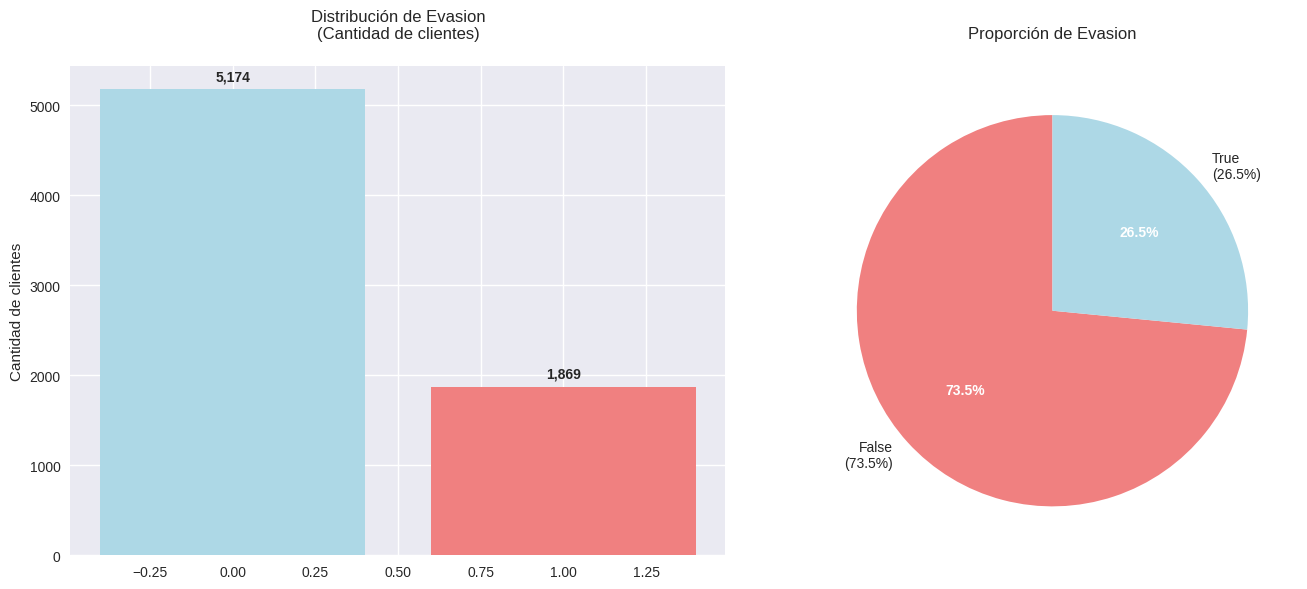



PASO 4: EVALUACIÓN Y NORMALIZACIÓN DE DATOS
Variables numéricas identificadas (20):

Análisis de escalas de las variables numéricas:
Variable             Min          Max          Media        Std          Rango       
-------------------------------------------------------------------------------------
EsAdultoMayor        0.00         1.00         0.16         0.37         1.00        
AntigüedadMeses      0.00         72.00        32.37        24.56        72.00       
CargosMensuales      18.25        118.75       64.76        30.09        100.50      
CargosTotales        18.80        8684.80      2283.30      2266.77      8666.00     
CargosDiarios        0.60         3.90         2.13         0.99         3.30        
Genero_Male          0.00         1.00         0.50         0.50         1.00        
MultiplesLineas_True 0.00         1.00         0.42         0.49         1.00        
TipoInternet_Fiber optic 0.00         1.00         0.44         0.50         1.00        
T

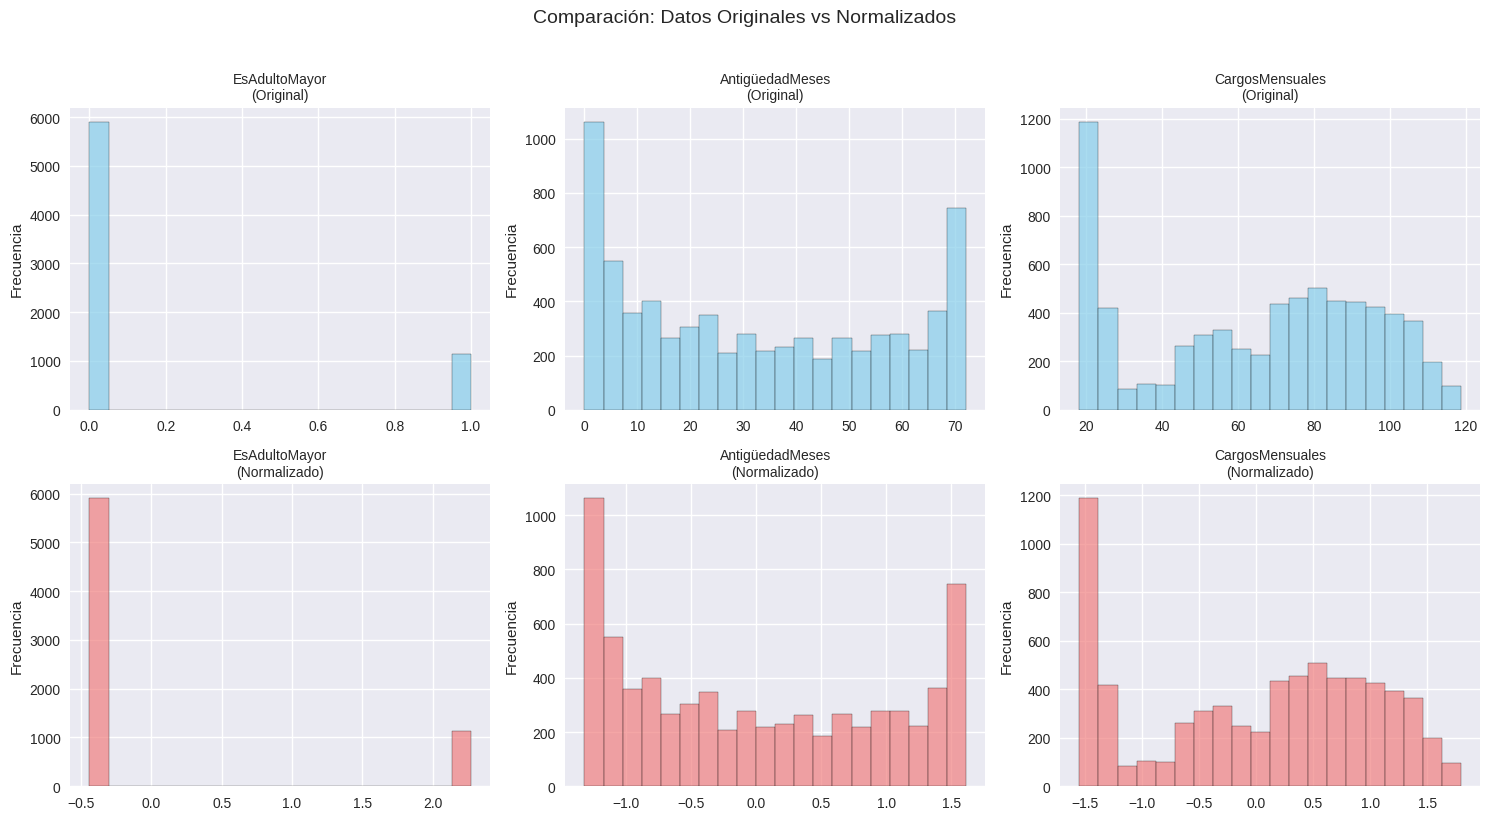


PREPARACIÓN DE DATOS COMPLETADA

Resumen final:
   • Dimensiones finales: (7043, 25)
   • Variables después del procesamiento: 25
   • Dataset normalizado
   • Balance de clases: DESBALANCE MODERADO


In [85]:
# Carga los datos
df = cargar_datos()

# Explora inicialmente
exploracion_inicial(df)

# Ejecuta los 4 pasos automáticamente
resultados = ejecutar_pasos_preparacion(df)

# **🎯 Correlación y Selección de Variables**

ANÁLISIS DE CORRELACIÓN CON EVASIÓN
Variables numéricas para análisis: 21

TOP 10 Variables más correlacionadas con Evasion:
Rank Variable                  Correlación  Nivel          
------------------------------------------------------------
1    AntigüedadMeses           0.352        MODERADA       
2    TipoInternet_Fiber optic  0.308        MODERADA       
3    TipoContrato_Two year     0.302        MODERADA       
4    MetodoPago_Electronic check 0.302        MODERADA       
5    TipoInternet_No           0.228        BAJA           
6    CargosTotales             0.199        BAJA           
7    CargosMensuales           0.193        BAJA           
8    CargosDiarios             0.193        BAJA           
9    TipoContrato_One year     0.178        BAJA           
10   SeguridadEnLinea_True     0.171        BAJA           


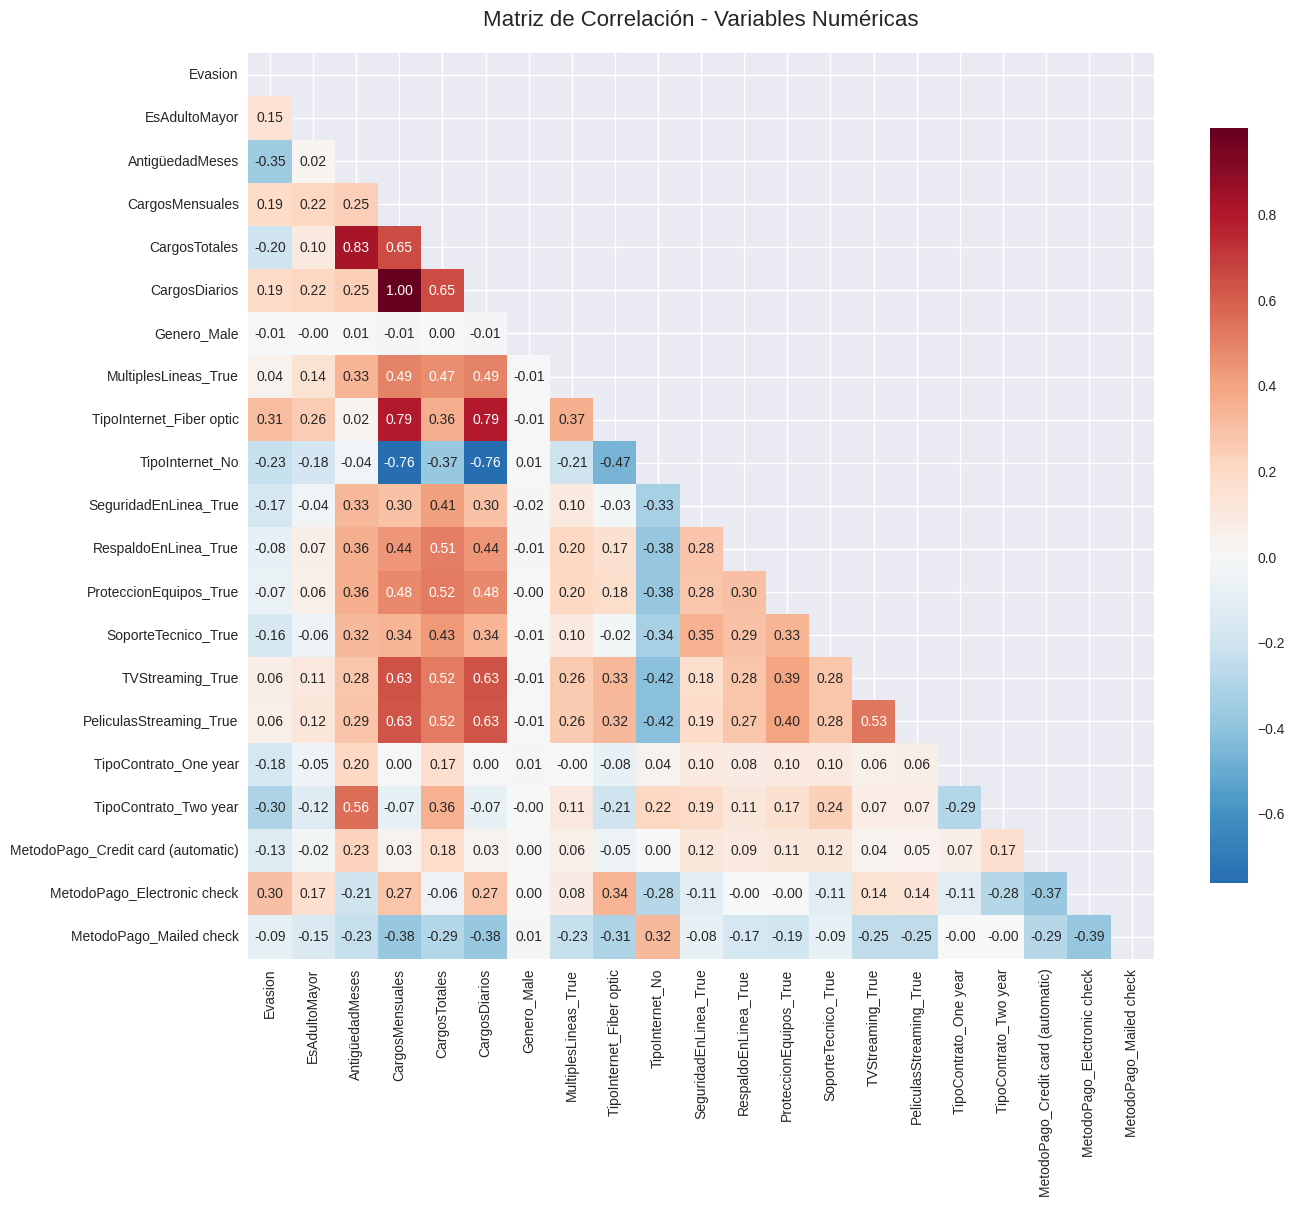

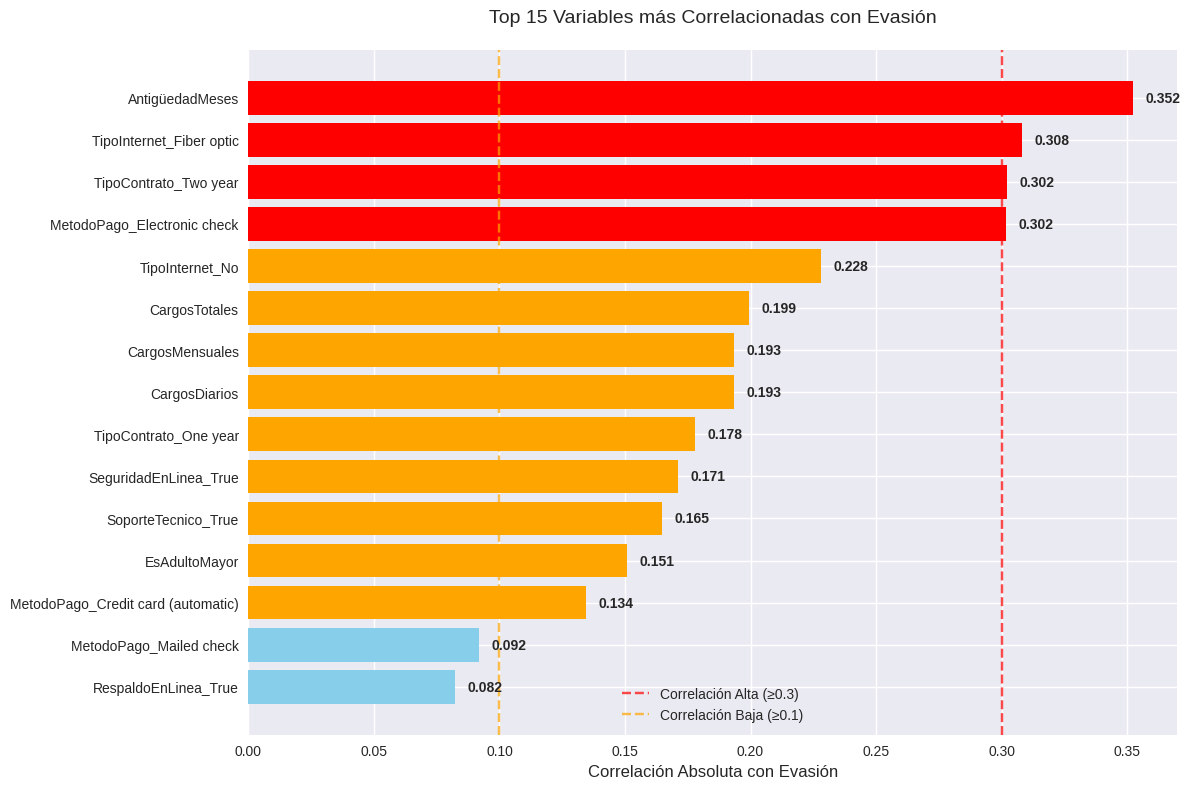

ANÁLISIS DE RELACIONES ESPECÍFICAS
Variables identificadas para análisis específico:
   TipoContrato: ['TipoContrato_One year', 'TipoContrato_Two year']
   CargosTotales: CargosTotales
   CargosMensuales: CargosMensuales

ANÁLISIS 1: Tipo de Contrato vs Evasión

Tasa de evasión por tipo de contrato:
   Two year: 26.5%


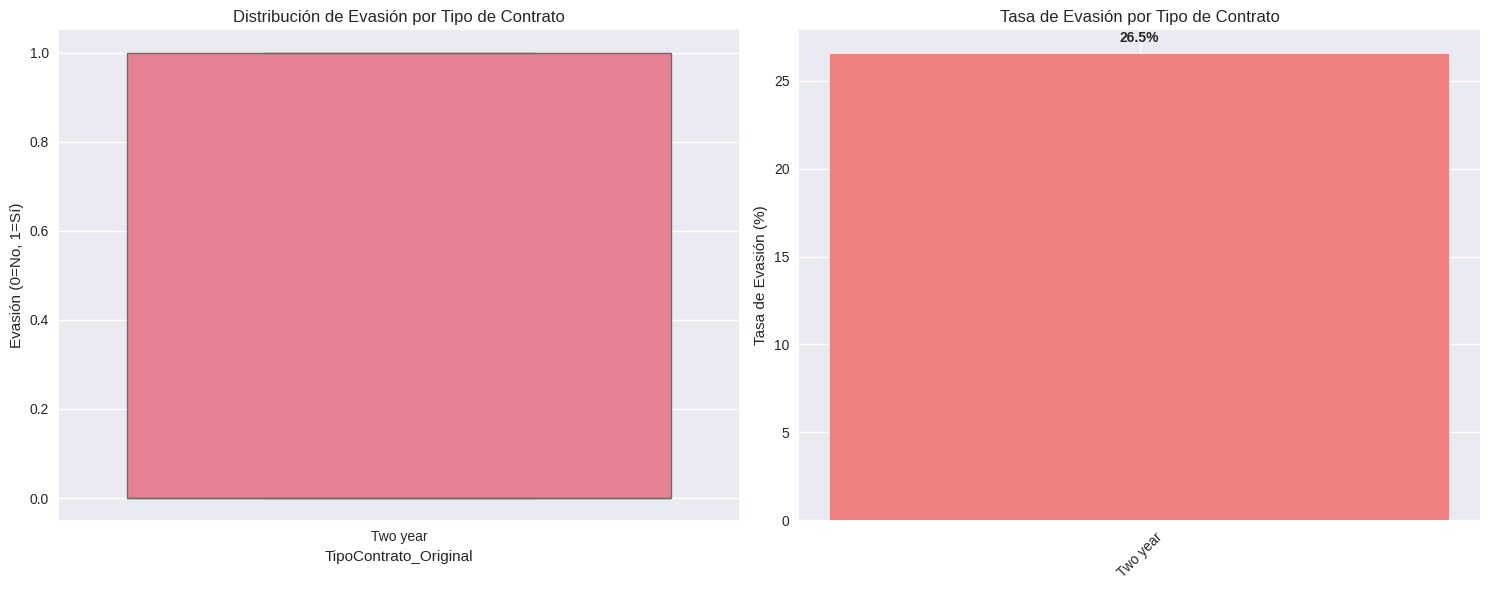


ANÁLISIS 2: Gastos vs Evasión

Estadísticas para CargosTotales:
   Sin evasión - Media: $0.12, Mediana: $-0.26
   Con evasión - Media: $-0.33, Mediana: $-0.70

Estadísticas para CargosMensuales:
   Sin evasión - Media: $-0.12, Mediana: $-0.01
   Con evasión - Media: $0.32, Mediana: $0.49


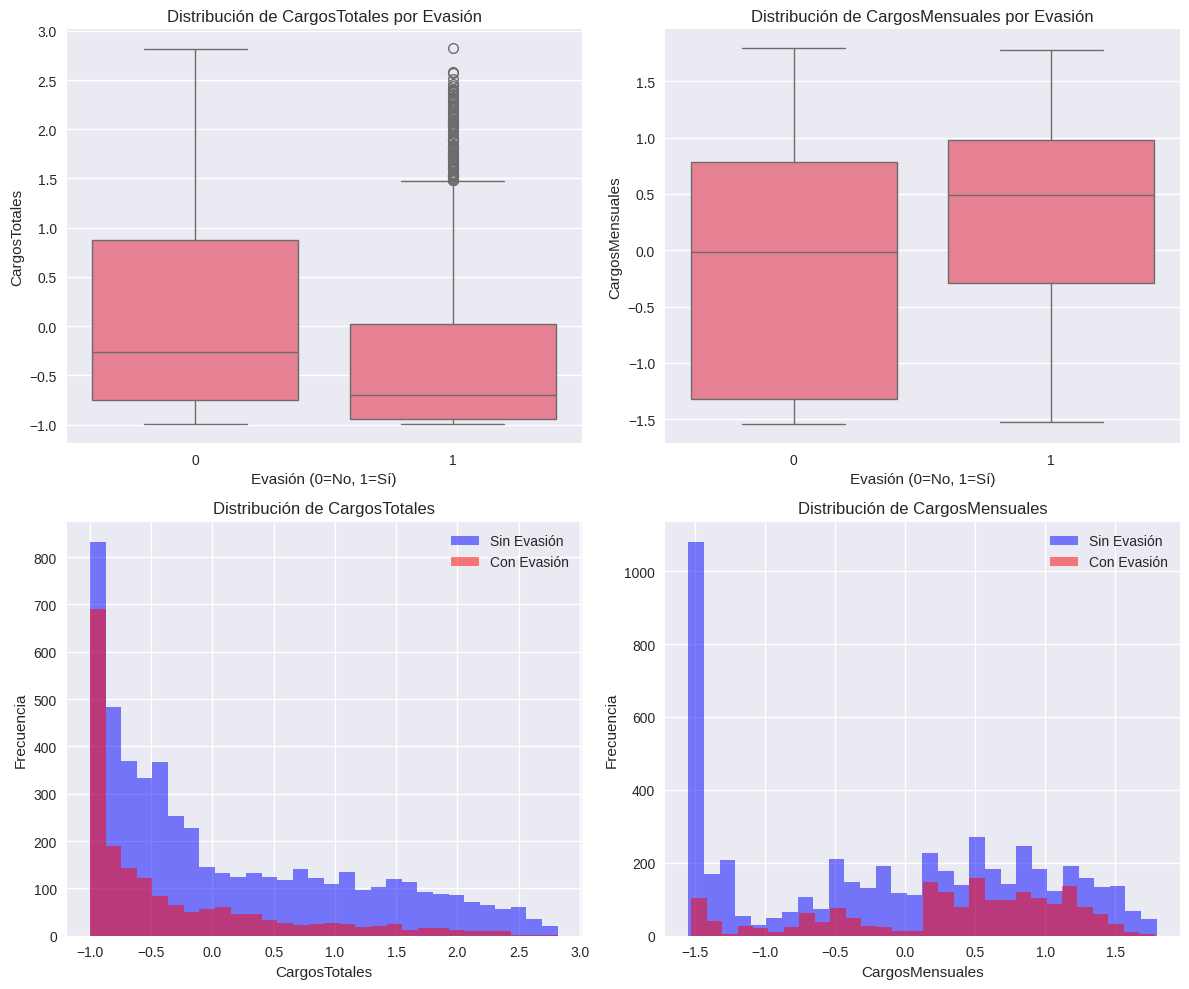

RESUMEN DE INSIGHTS - CORRELACIÓN
VARIABLES CON ALTA CORRELACIÓN (≥ 0.3):
   AntigüedadMeses: 0.352
   TipoInternet_Fiber optic: 0.308
   TipoContrato_Two year: 0.302
   MetodoPago_Electronic check: 0.302
   Estas 4 variables son candidatas PRIORITARIAS para el modelo

VARIABLES CON CORRELACIÓN MODERADA (0.1 - 0.3):
   TipoInternet_No: 0.228
   CargosTotales: 0.199
   CargosMensuales: 0.193
   CargosDiarios: 0.193
   TipoContrato_One year: 0.178
   ... y 4 más
   Estas variables pueden complementar el modelo

RECOMENDACIONES PARA SELECCIÓN DE VARIABLES:
   Tienes 13 variables relevantes
   Considera usar las top 10-15 para evitar overfitting
   Aplica técnicas de selección de características si es necesario

PRÓXIMOS PASOS SUGERIDOS:
   1. Usar las variables de alta correlación como base del modelo
   2. Evaluar multicolinealidad entre variables predictoras
   3. Considerar interacciones entre variables importantes
   4. Dividir datos en train/test usando estas variables seleccionadas


In [86]:
df_preparado = resultados['paso4']['df']
correlaciones, matriz = analizar_correlacion_evasion(df_preparado)
analizar_relaciones_especificas(df_preparado)
resumen_insights_correlacion(correlaciones)

In [87]:
# ==========================================
# CORRELACIÓN Y SELECCIÓN DE VARIABLES
# ==========================================

def analizar_correlacion_evasion(df, columna_objetivo='Evasion'):
    """
    Analiza la correlación entre variables numéricas y la evasión

    Args:
        df (pd.DataFrame): DataFrame preparado
        columna_objetivo (str): Nombre de la columna objetivo
    """
    print("=" * 60)
    print("ANÁLISIS DE CORRELACIÓN CON EVASIÓN")
    print("=" * 60)

    # Preparar datos para correlación
    df_corr = df.copy()
    if df_corr[columna_objetivo].dtype in ['object', 'bool']:
        df_corr[columna_objetivo] = df_corr[columna_objetivo].astype(int)

    # Calcular matriz de correlación para variables numéricas
    numericas = df_corr.select_dtypes(include=[np.number]).columns.tolist()
    matriz_correlacion = df_corr[numericas].corr()

    # Correlaciones con la variable objetivo
    correlaciones_objetivo = matriz_correlacion[columna_objetivo].abs().sort_values(ascending=False)
    correlaciones_objetivo = correlaciones_objetivo.drop(columna_objetivo)

    print(f"Variables numéricas para análisis: {len(numericas)}")
    print(f"\nTOP 10 Variables más correlacionadas con {columna_objetivo}:")
    print(f"{'Rank':<4} {'Variable':<25} {'Correlación':<12} {'Nivel':<15}")
    print("-" * 60)

    for i, (variable, corr) in enumerate(correlaciones_objetivo.head(10).items(), 1):
        if corr >= 0.5:
            nivel = "ALTA"
        elif corr >= 0.3:
            nivel = "MODERADA"
        elif corr >= 0.1:
            nivel = "BAJA"
        else:
            nivel = "MUY BAJA"
        print(f"{i:<4} {variable:<25} {corr:<12.3f} {nivel:<15}")

    # Visualización de matriz de correlación
    plt.figure(figsize=(14, 12))
    mask = np.triu(np.ones_like(matriz_correlacion, dtype=bool))
    sns.heatmap(matriz_correlacion, mask=mask, annot=True, cmap='RdBu_r',
                center=0, square=True, fmt='.2f', cbar_kws={"shrink": .8})
    plt.title('Matriz de Correlación - Variables Numéricas', fontsize=16, pad=20)
    plt.tight_layout()
    plt.show()

    # Visualización de correlaciones con evasión
    plt.figure(figsize=(12, 8))
    top_correlaciones = correlaciones_objetivo.head(15)
    colors = ['red' if x >= 0.3 else 'orange' if x >= 0.1 else 'skyblue'
              for x in top_correlaciones.values]

    bars = plt.barh(range(len(top_correlaciones)), top_correlaciones.values, color=colors)
    plt.yticks(range(len(top_correlaciones)), top_correlaciones.index)
    plt.xlabel('Correlación Absoluta con Evasión', fontsize=12)
    plt.title('Top 15 Variables más Correlacionadas con Evasión', fontsize=14, pad=20)
    plt.gca().invert_yaxis()

    # Añadir valores en barras
    for i, bar in enumerate(bars):
        width = bar.get_width()
        plt.text(width + 0.005, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontweight='bold')

    # Líneas de referencia
    plt.axvline(x=0.3, color='red', linestyle='--', alpha=0.7, label='Correlación Alta (≥0.3)')
    plt.axvline(x=0.1, color='orange', linestyle='--', alpha=0.7, label='Correlación Baja (≥0.1)')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return correlaciones_objetivo, matriz_correlacion


def analizar_relaciones_especificas(df, columna_objetivo='Evasion'):
    """
    Analiza relaciones específicas entre variables clave y la evasión

    Args:
        df (pd.DataFrame): DataFrame preparado
        columna_objetivo (str): Nombre de la columna objetivo
    """
    print("=" * 60)
    print("ANÁLISIS DE RELACIONES ESPECÍFICAS")
    print("=" * 60)

    # Preparar datos
    df_analisis = df.copy()
    if df_analisis[columna_objetivo].dtype in ['object', 'bool']:
        df_analisis[columna_objetivo] = df_analisis[columna_objetivo].astype(int)

    # Identificar variables disponibles
    variables_interes = {
        'TipoContrato': ['TipoContrato_Month-to-month', 'TipoContrato_One year', 'TipoContrato_Two year'],
        'CargosTotales': 'CargosTotales',
        'CargosMensuales': 'CargosMensuales',
        'AntigüedadMeses': 'AntigÃ¼edadMeses'
    }

    variables_disponibles = {}
    for categoria, vars_list in variables_interes.items():
        if isinstance(vars_list, list):
            vars_existentes = [var for var in vars_list if var in df_analisis.columns]
            if vars_existentes:
                variables_disponibles[categoria] = vars_existentes
        else:
            if vars_list in df_analisis.columns:
                variables_disponibles[categoria] = vars_list

    print("Variables identificadas para análisis específico:")
    for categoria, variables in variables_disponibles.items():
        print(f"   {categoria}: {variables}")

    # ANÁLISIS 1: Tipo de Contrato vs Evasión
    if 'TipoContrato' in variables_disponibles:
        print("\nANÁLISIS 1: Tipo de Contrato vs Evasión")

        # Reconstruir variable categórica
        df_analisis['TipoContrato_Original'] = 'Two year'
        for var in variables_disponibles['TipoContrato']:
            if 'Month-to-month' in var:
                df_analisis.loc[df_analisis[var] == 1, 'TipoContrato_Original'] = 'Month-to-month'
            elif 'One year' in var:
                df_analisis.loc[df_analisis[var] == 1, 'TipoContrato_Original'] = 'One year'

        # Calcular tasas de evasión
        tabla_contrato = pd.crosstab(df_analisis['TipoContrato_Original'],
                                    df_analisis[columna_objetivo], normalize='index') * 100

        print("\nTasa de evasión por tipo de contrato:")
        for contrato in tabla_contrato.index:
            tasa_evasion = tabla_contrato.loc[contrato, 1] if 1 in tabla_contrato.columns else 0
            print(f"   {contrato}: {tasa_evasion:.1f}%")

        # Visualización
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        sns.boxplot(data=df_analisis, x='TipoContrato_Original', y=columna_objetivo, ax=ax1)
        ax1.set_title('Distribución de Evasión por Tipo de Contrato')
        ax1.set_ylabel('Evasión (0=No, 1=Sí)')

        tasa_evasion_contrato = df_analisis.groupby('TipoContrato_Original')[columna_objetivo].mean() * 100
        bars = ax2.bar(tasa_evasion_contrato.index, tasa_evasion_contrato.values,
                      color=['lightcoral', 'lightblue', 'lightgreen'])
        ax2.set_title('Tasa de Evasión por Tipo de Contrato')
        ax2.set_ylabel('Tasa de Evasión (%)')
        ax2.tick_params(axis='x', rotation=45)

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()

    # ANÁLISIS 2: Gastos vs Evasión
    variables_gastos = [v for k, v in variables_disponibles.items()
                       if k in ['CargosTotales', 'CargosMensuales'] and isinstance(v, str)]

    if variables_gastos:
        print("\nANÁLISIS 2: Gastos vs Evasión")

        fig, axes = plt.subplots(2, len(variables_gastos), figsize=(6*len(variables_gastos), 10))
        if len(variables_gastos) == 1:
            axes = axes.reshape(-1, 1)

        for i, variable_gasto in enumerate(variables_gastos):
            stats_no_evasion = df_analisis[df_analisis[columna_objetivo] == 0][variable_gasto].describe()
            stats_evasion = df_analisis[df_analisis[columna_objetivo] == 1][variable_gasto].describe()

            print(f"\nEstadísticas para {variable_gasto}:")
            print(f"   Sin evasión - Media: ${stats_no_evasion['mean']:.2f}, Mediana: ${stats_no_evasion['50%']:.2f}")
            print(f"   Con evasión - Media: ${stats_evasion['mean']:.2f}, Mediana: ${stats_evasion['50%']:.2f}")

            sns.boxplot(data=df_analisis, x=columna_objetivo, y=variable_gasto, ax=axes[0, i])
            axes[0, i].set_title(f'Distribución de {variable_gasto} por Evasión')
            axes[0, i].set_xlabel('Evasión (0=No, 1=Sí)')

            axes[1, i].hist(df_analisis[df_analisis[columna_objetivo] == 0][variable_gasto],
                           alpha=0.5, label='Sin Evasión', bins=30, color='blue')
            axes[1, i].hist(df_analisis[df_analisis[columna_objetivo] == 1][variable_gasto],
                           alpha=0.5, label='Con Evasión', bins=30, color='red')
            axes[1, i].set_title(f'Distribución de {variable_gasto}')
            axes[1, i].set_xlabel(variable_gasto)
            axes[1, i].set_ylabel('Frecuencia')
            axes[1, i].legend()

        plt.tight_layout()
        plt.show()

    # ANÁLISIS 3: Antigüedad vs Evasión
    if 'AntigüedadMeses' in variables_disponibles:
        print("\nANÁLISIS 3: Antigüedad vs Evasión")

        variable_antiguedad = variables_disponibles['AntigüedadMeses']

        df_analisis['GrupoAntiguedad'] = pd.cut(df_analisis[variable_antiguedad],
                                               bins=[0, 12, 24, 36, 48, float('inf')],
                                               labels=['0-12 meses', '13-24 meses', '25-36 meses',
                                                      '37-48 meses', '49+ meses'])

        tasa_por_grupo = df_analisis.groupby('GrupoAntiguedad')[columna_objetivo].mean() * 100

        print("\nTasa de evasión por grupo de antigüedad:")
        for grupo, tasa in tasa_por_grupo.items():
            print(f"   {grupo}: {tasa:.1f}%")

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.scatter(df_analisis[df_analisis[columna_objetivo] == 0][variable_antiguedad],
                   df_analisis[df_analisis[columna_objetivo] == 0][columna_objetivo],
                   alpha=0.5, label='Sin Evasión', color='blue')
        ax1.scatter(df_analisis[df_analisis[columna_objetivo] == 1][variable_antiguedad],
                   df_analisis[df_analisis[columna_objetivo] == 1][columna_objetivo],
                   alpha=0.5, label='Con Evasión', color='red')
        ax1.set_xlabel('Antigüedad (Meses)')
        ax1.set_ylabel('Evasión')
        ax1.set_title('Relación Antigüedad vs Evasión')
        ax1.legend()

        bars = ax2.bar(range(len(tasa_por_grupo)), tasa_por_grupo.values,
                      color=['lightcoral', 'orange', 'lightblue', 'lightgreen', 'purple'])
        ax2.set_xticks(range(len(tasa_por_grupo)))
        ax2.set_xticklabels(tasa_por_grupo.index, rotation=45)
        ax2.set_ylabel('Tasa de Evasión (%)')
        ax2.set_title('Tasa de Evasión por Grupo de Antigüedad')

        for bar in bars:
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.5,
                    f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

        plt.tight_layout()
        plt.show()


def resumen_insights_correlacion(correlaciones_objetivo):
    """
    Genera un resumen de insights basado en el análisis de correlación

    Args:
        correlaciones_objetivo (pd.Series): Correlaciones con la variable objetivo
    """
    print("=" * 60)
    print("RESUMEN DE INSIGHTS - CORRELACIÓN")
    print("=" * 60)

    alta_correlacion = correlaciones_objetivo[correlaciones_objetivo >= 0.3]
    moderada_correlacion = correlaciones_objetivo[
        (correlaciones_objetivo >= 0.1) & (correlaciones_objetivo < 0.3)
    ]

    print("VARIABLES CON ALTA CORRELACIÓN (≥ 0.3):")
    if len(alta_correlacion) > 0:
        for variable, corr in alta_correlacion.items():
            print(f"   {variable}: {corr:.3f}")
        print(f"   Estas {len(alta_correlacion)} variables son candidatas PRIORITARIAS para el modelo")
    else:
        print("   No se encontraron variables con alta correlación")

    print("\nVARIABLES CON CORRELACIÓN MODERADA (0.1 - 0.3):")
    if len(moderada_correlacion) > 0:
        for variable, corr in moderada_correlacion.head(5).items():
            print(f"   {variable}: {corr:.3f}")
        if len(moderada_correlacion) > 5:
            print(f"   ... y {len(moderada_correlacion) - 5} más")
        print("   Estas variables pueden complementar el modelo")
    else:
        print("   No se encontraron variables con correlación moderada")

    # Recomendaciones
    total_importantes = len(alta_correlacion) + len(moderada_correlacion)
    print("\nRECOMENDACIONES PARA SELECCIÓN DE VARIABLES:")

    if total_importantes >= 10:
        print(f"   Tienes {total_importantes} variables relevantes")
        print("   Considera usar las top 10-15 para evitar overfitting")
        print("   Aplica técnicas de selección de características si es necesario")
    elif total_importantes >= 5:
        print(f"   Tienes {total_importantes} variables relevantes")
        print("   Número adecuado para un buen modelo")
        print("   Puedes usar todas estas variables")
    else:
        print(f"   Solo {total_importantes} variables muestran correlación relevante")
        print("   Considera crear nuevas características (feature engineering)")
        print("   Evalúa variables categóricas y su relación con evasión")

    print("\nPRÓXIMOS PASOS SUGERIDOS:")
    print("   1. Usar las variables de alta correlación como base del modelo")
    print("   2. Evaluar multicolinealidad entre variables predictoras")
    print("   3. Considerar interacciones entre variables importantes")
    print("   4. Dividir datos en train/test usando estas variables seleccionadas")


def ejecutar_analisis_correlacion(df, columna_objetivo='Evasion'):
    """
    Ejecuta el análisis completo de correlación y selección de variables

    Args:
        df (pd.DataFrame): DataFrame preparado
        columna_objetivo (str): Nombre de la columna objetivo

    Returns:
        dict: Resultados del análisis
    """
    print("EJECUTANDO ANÁLISIS COMPLETO DE CORRELACIÓN")
    print("=" * 60)

    correlaciones_objetivo, matriz_correlacion = analizar_correlacion_evasion(df, columna_objetivo)
    print("\n" + "="*60 + "\n")

    analizar_relaciones_especificas(df, columna_objetivo)
    print("\n" + "="*60 + "\n")

    resumen_insights_correlacion(correlaciones_objetivo)

    resultados = {
        'correlaciones_objetivo': correlaciones_objetivo,
        'matriz_correlacion': matriz_correlacion,
        'variables_alta_correlacion': correlaciones_objetivo[correlaciones_objetivo >= 0.3].index.tolist(),
        'variables_moderada_correlacion': correlaciones_objetivo[
            (correlaciones_objetivo >= 0.1) & (correlaciones_objetivo < 0.3)
        ].index.tolist()
    }

    print(f"\nAnálisis de correlación completado")
    print(f"Variables de alta correlación: {len(resultados['variables_alta_correlacion'])}")
    print(f"Variables de correlación moderada: {len(resultados['variables_moderada_correlacion'])}")

    return resultados

In [88]:
resultados

{'paso1': {'df':       Evasion  Genero  EsAdultoMayor  TienePareja  TieneDependientes  \
  0       False  Female              0         True               True   
  1       False    Male              0        False              False   
  2        True    Male              0        False              False   
  3        True    Male              1         True              False   
  4        True  Female              1         True              False   
  ...       ...     ...            ...          ...                ...   
  7038    False  Female              0        False              False   
  7039     True    Male              0         True              False   
  7040    False    Male              0        False              False   
  7041    False    Male              0         True               True   
  7042    False    Male              0         True               True   
  
        AntigüedadMeses  ServicioTelefonico MultiplesLineas TipoInternet  \
  0               

#**🤖 Modelado Predictivo**

In [89]:
# =============================================================================
# DIAGNÓSTICO Y LIMPIEZA DE DATOS ANTES DEL MODELADO
# =============================================================================

def diagnosticar_datos_antes_modelado(df_preparado, columna_objetivo='Evasion'):
    """
    Diagnostica y limpia problemas en el dataset antes del modelado.

    Args:
        df_preparado: DataFrame procesado que puede tener problemas
        columna_objetivo: Nombre de la variable objetivo

    Returns:
        DataFrame: Dataset limpio y listo para modelado
    """
    print("=" * 70)
    print("DIAGNÓSTICO Y LIMPIEZA DE DATOS")
    print("=" * 70)

    df_limpio = df_preparado.copy()
    print(f"Dimensiones iniciales: {df_limpio.shape}")

    # 1. VERIFICAR VALORES NULOS
    print("\nVERIFICACIÓN DE VALORES NULOS:")
    valores_nulos = df_limpio.isnull().sum()
    columnas_con_nulos = valores_nulos[valores_nulos > 0]

    if len(columnas_con_nulos) > 0:
        print(f"ENCONTRADOS {len(columnas_con_nulos)} columnas con valores nulos:")
        for col, nulos in columnas_con_nulos.items():
            porcentaje = (nulos / len(df_limpio)) * 100
            print(f"   {col}: {nulos} nulos ({porcentaje:.1f}%)")

        print("\nAPLICANDO LIMPIEZA:")

        # Variables numéricas: rellenar con mediana
        cols_numericas = df_limpio.select_dtypes(include=[np.number]).columns
        cols_numericas_con_nulos = [col for col in cols_numericas if col in columnas_con_nulos.index]

        for col in cols_numericas_con_nulos:
            mediana = df_limpio[col].median()
            df_limpio[col].fillna(mediana, inplace=True)
            print(f"   {col}: rellenado con mediana = {mediana:.2f}")

        # Variables categóricas: rellenar con moda
        cols_categoricas_con_nulos = [col for col in columnas_con_nulos.index if col not in cols_numericas]

        for col in cols_categoricas_con_nulos:
            moda = df_limpio[col].mode()[0]
            df_limpio[col].fillna(moda, inplace=True)
            print(f"   {col}: rellenado con moda = {moda}")
    else:
        print("No se encontraron valores nulos")

    # 2. VERIFICAR TIPOS DE DATOS
    print("\nVERIFICACIÓN DE TIPOS DE DATOS:")
    tipos = df_limpio.dtypes.value_counts()
    for tipo, cantidad in tipos.items():
        print(f"   {tipo}: {cantidad} columnas")

    # 3. VERIFICAR VARIABLE OBJETIVO
    print(f"\nVERIFICACIÓN DE VARIABLE OBJETIVO '{columna_objetivo}':")
    if columna_objetivo not in df_limpio.columns:
        print(f"ERROR: Variable objetivo '{columna_objetivo}' no encontrada")
        print(f"Columnas disponibles: {list(df_limpio.columns)}")
        return None

    # Convertir variable objetivo a numérica si es booleana
    if df_limpio[columna_objetivo].dtype == 'bool':
        print(f"   Convirtiendo {columna_objetivo} de bool a int...")
        df_limpio[columna_objetivo] = df_limpio[columna_objetivo].astype(int)

    valores_objetivo = df_limpio[columna_objetivo].value_counts()
    print(f"   Clases encontradas: {dict(valores_objetivo)}")

    # 4. VERIFICAR INFINITOS
    print("\nVERIFICACIÓN DE VALORES INFINITOS:")
    cols_numericas = df_limpio.select_dtypes(include=[np.number]).columns
    infinitos_encontrados = False

    for col in cols_numericas:
        inf_count = np.isinf(df_limpio[col]).sum()
        if inf_count > 0:
            print(f"   {col}: {inf_count} valores infinitos")
            df_limpio[col].replace([np.inf, -np.inf], np.nan, inplace=True)
            df_limpio[col].fillna(df_limpio[col].median(), inplace=True)
            print(f"     Reemplazados con mediana")
            infinitos_encontrados = True

    if not infinitos_encontrados:
        print("   No se encontraron valores infinitos")

    # 5. VERIFICACIÓN FINAL
    print("\nVERIFICACIÓN FINAL:")
    print(f"   Dimensiones finales: {df_limpio.shape}")
    print(f"   Valores nulos restantes: {df_limpio.isnull().sum().sum()}")
    print("   Tipos de datos estables: OK")
    print("   Variable objetivo lista: OK")

    return df_limpio


def dividir_datos_estratificado(df_preparado, columna_objetivo='Evasion', test_size=0.3, random_state=42):
    """
    Divide el dataset preparado en entrenamiento y prueba de forma estratificada.

    Args:
        df_preparado: DataFrame ya procesado
        columna_objetivo: Nombre de la variable objetivo
        test_size: Proporción para test (0.3 = 30%, 0.2 = 20%)
        random_state: Semilla para reproducibilidad

    Returns:
        dict: Contiene X_train, X_test, y_train, y_test e información adicional
    """
    print("=" * 70)
    print("DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA")
    print("=" * 70)

    # Separar características y variable objetivo
    X = df_preparado.drop(columns=[columna_objetivo])
    y = df_preparado[columna_objetivo]

    print("Información del dataset:")
    print(f"   Total de registros: {len(df_preparado):,}")
    print(f"   Características disponibles: {X.shape[1]}")
    print(f"   Variable objetivo: {columna_objetivo}")

    # Analizar balance antes de dividir
    balance_original = y.value_counts()
    proporcion_original = y.value_counts(normalize=True)

    print("\nBalance de clases original:")
    for clase, cantidad in balance_original.items():
        porcentaje = proporcion_original[clase] * 100
        print(f"   {clase}: {cantidad:,} registros ({porcentaje:.1f}%)")

    # División estratificada
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    print(f"\nDivisión realizada ({int((1-test_size)*100)}/{int(test_size*100)}):")
    print(f"   Entrenamiento: {len(X_train):,} registros")
    print(f"   Prueba: {len(X_test):,} registros")

    # Verificar estratificación
    balance_train = y_train.value_counts(normalize=True)
    balance_test = y_test.value_counts(normalize=True)

    print("\nVerificación de estratificación:")
    print("   Original  | Entrenamiento | Prueba")
    for clase in balance_original.index:
        orig = proporcion_original[clase] * 100
        train = balance_train[clase] * 100
        test = balance_test[clase] * 100
        print(f"   {clase}: {orig:5.1f}%  |     {train:5.1f}%     | {test:5.1f}%")

    return {
        'X_train': X_train,
        'X_test': X_test,
        'y_train': y_train,
        'y_test': y_test,
        'info': {
            'test_size': test_size,
            'total_registros': len(df_preparado),
            'n_caracteristicas': X.shape[1],
            'balance_original': balance_original.to_dict(),
            'proporcion_original': proporcion_original.to_dict()
        }
    }


def construir_modelos_churn(datos_division):
    """
    Construye 4 modelos diferentes para predicción de churn.

    MODELOS CON NORMALIZACIÓN (sensibles a escala):
    - Regresión Logística: Optimización por gradientes
    - K-Nearest Neighbors: Cálculo de distancias

    MODELOS SIN NORMALIZACIÓN (no sensibles a escala):
    - Random Forest: Decisiones por umbrales
    - Árbol de Decisión: Solo importa orden relativo

    Args:
        datos_division: Resultado de dividir_datos_estratificado()

    Returns:
        dict: Modelos entrenados y datos normalizados
    """
    print("\n" + "=" * 70)
    print("CONSTRUCCIÓN DE MODELOS DE CLASIFICACIÓN")
    print("=" * 70)

    # Extraer datos
    X_train = datos_division['X_train']
    X_test = datos_division['X_test']
    y_train = datos_division['y_train']
    y_test = datos_division['y_test']

    print("JUSTIFICACIÓN TÉCNICA PARA NORMALIZACIÓN:")
    print("-" * 50)
    print("MODELOS QUE REQUIEREN NORMALIZACIÓN:")
    print("   • Regresión Logística:")
    print("     - Usa optimización por gradientes")
    print("     - Variables con mayor escala dominan la optimización")
    print("     - Los coeficientes se vuelven incomparables")
    print()
    print("   • K-Nearest Neighbors:")
    print("     - Calcula distancias euclideas entre puntos")
    print("     - Variables con mayor escala dominan el cálculo de distancia")
    print("     - Variables de diferentes escalas distorsionan las distancias")
    print()
    print("MODELOS QUE NO REQUIEREN NORMALIZACIÓN:")
    print("   • Random Forest:")
    print("     - Usa árboles que dividen por umbrales óptimos")
    print("     - Las divisiones son invariantes a la escala")
    print("     - Solo importa el orden relativo de los valores")
    print()
    print("   • Árbol de Decisión:")
    print("     - Selecciona puntos de corte óptimos para cada variable")
    print("     - Solo importa el orden relativo, no la magnitud")

    # Analizar escalas de variables numéricas
    variables_numericas = X_train.select_dtypes(include=[np.number]).columns.tolist()

    print("\nANÁLISIS DE ESCALAS ACTUALES:")
    print("-" * 50)
    escalas_info = {}

    for var in variables_numericas[:5]:
        media = X_train[var].mean()
        std = X_train[var].std()
        minimo = X_train[var].min()
        maximo = X_train[var].max()
        rango = maximo - minimo

        escalas_info[var] = {
            'media': media, 'std': std, 'min': minimo,
            'max': maximo, 'rango': rango
        }

        print(f"   {var[:20]:<20}: Rango [{minimo:8.1f}, {maximo:8.1f}] (Amplitud: {rango:8.1f})")

    if len(variables_numericas) > 5:
        print(f"   ... y {len(variables_numericas) - 5} variables más")

    # NORMALIZACIÓN
    print("\nAPLICANDO NORMALIZACIÓN (StandardScaler):")
    print("-" * 50)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

    print("Normalización aplicada correctamente:")
    print("   • Scaler ajustado SOLO con datos de entrenamiento")
    print("   • Datos de prueba transformados con parámetros de entrenamiento")
    print("   • Variables numéricas con media ≈ 0 y std ≈ 1")

    # Verificar normalización
    print("\nVERIFICACIÓN (primeras 3 variables):")
    for var in variables_numericas[:3]:
        media_norm = X_train_scaled[var].mean()
        std_norm = X_train_scaled[var].std()
        print(f"   {var[:20]:<20}: Media = {media_norm:6.3f}, Std = {std_norm:6.3f}")

    # ENTRENAMIENTO DE MODELOS
    print("\nENTRENANDO MODELOS:")
    print("-" * 50)

    modelos = {}

    # 1. Regresión Logística (CON normalización)
    print("1. Regresión Logística (datos normalizados)...")
    lr_model = LogisticRegression(random_state=42, max_iter=1000)
    lr_model.fit(X_train_scaled, y_train)
    modelos['logistic_regression'] = {
        'modelo': lr_model,
        'normalizado': True,
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'nombre': 'Regresión Logística',
        'justificacion': 'Requiere normalización por optimización por gradientes'
    }
    print("   Modelo entrenado con datos normalizados")

    # 2. K-Nearest Neighbors (CON normalización)
    print("2. K-Nearest Neighbors (datos normalizados)...")
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train_scaled, y_train)
    modelos['knn'] = {
        'modelo': knn_model,
        'normalizado': True,
        'X_train': X_train_scaled,
        'X_test': X_test_scaled,
        'nombre': 'K-Nearest Neighbors',
        'justificacion': 'Requiere normalización por cálculo de distancias'
    }
    print("   Modelo entrenado con datos normalizados")

    # 3. Random Forest (SIN normalización)
    print("3. Random Forest (datos originales)...")
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    modelos['random_forest'] = {
        'modelo': rf_model,
        'normalizado': False,
        'X_train': X_train,
        'X_test': X_test,
        'nombre': 'Random Forest',
        'justificacion': 'No requiere normalización por usar umbrales de decisión'
    }
    print("   Modelo entrenado con datos originales")

    # 4. Árbol de Decisión (SIN normalización)
    print("4. Árbol de Decisión (datos originales)...")
    dt_model = DecisionTreeClassifier(random_state=42, max_depth=10)
    dt_model.fit(X_train, y_train)
    modelos['decision_tree'] = {
        'modelo': dt_model,
        'normalizado': False,
        'X_train': X_train,
        'X_test': X_test,
        'nombre': 'Árbol de Decisión',
        'justificacion': 'No requiere normalización por selección de umbrales'
    }
    print("   Modelo entrenado con datos originales")

    print("\nRESUMEN DE MODELOS CONSTRUIDOS:")
    print("-" * 50)
    for key, info in modelos.items():
        normalizacion = "SÍ" if info['normalizado'] else "NO"
        print(f"   • {info['nombre']:<20}: Normalización {normalizacion}")
        print(f"     Razón: {info['justificacion']}")

    return {
        'modelos': modelos,
        'scaler': scaler,
        'datos_originales': {
            'X_train': X_train, 'X_test': X_test,
            'y_train': y_train, 'y_test': y_test
        },
        'datos_normalizados': {
            'X_train': X_train_scaled, 'X_test': X_test_scaled
        },
        'escalas_info': escalas_info
    }


def ejecutar_division_y_modelado(df_preparado, test_size=0.3):
    """
    Ejecuta división de datos y construcción de modelos completa.

    Args:
        df_preparado: DataFrame del paso 4
        test_size: Proporción para test (0.3 = 30%, 0.2 = 20%)

    Returns:
        dict: Resultados completos listos para evaluación
    """
    print("EJECUTANDO DIVISIÓN DE DATOS Y MODELADO COMPLETO")
    print("=" * 80)
    print(f"Dataset de entrada: {df_preparado.shape[0]} registros, {df_preparado.shape[1]} variables")

    # Paso 0: Diagnóstico y limpieza
    print("\nPASO 0: Diagnóstico y limpieza de datos...")
    df_limpio = diagnosticar_datos_antes_modelado(df_preparado)

    if df_limpio is None:
        print("Error en la limpieza de datos. Abortando proceso.")
        return None

    # Paso 1: Dividir datos
    print("\nPASO 1: División estratificada de datos...")
    datos_division = dividir_datos_estratificado(df_limpio, test_size=test_size)

    # Paso 2: Construir modelos
    print("\nPASO 2: Construcción y entrenamiento de modelos...")
    resultados_modelos = construir_modelos_churn(datos_division)

    # Combinar resultados
    resultados_finales = {
        'datos_limpios': df_limpio,
        'division_datos': datos_division,
        'modelos_entrenados': resultados_modelos,
        'configuracion': {
            'test_size': test_size,
            'total_modelos': len(resultados_modelos['modelos']),
            'modelos_normalizados': sum(1 for m in resultados_modelos['modelos'].values() if m['normalizado']),
            'modelos_originales': sum(1 for m in resultados_modelos['modelos'].values() if not m['normalizado'])
        }
    }

    print("\nDIVISIÓN Y MODELADO COMPLETADOS EXITOSAMENTE!")
    print("=" * 80)
    print(f"{resultados_finales['configuracion']['total_modelos']} modelos entrenados:")
    print(f"   • {resultados_finales['configuracion']['modelos_normalizados']} con normalización")
    print(f"   • {resultados_finales['configuracion']['modelos_originales']} sin normalización")
    print(f"División: {len(datos_division['X_train'])} train / {len(datos_division['X_test'])} test")
    print("Datos listos para evaluación y métricas")

    print("\nACCESO A LOS RESULTADOS:")
    print("   • Modelos: resultados['modelos_entrenados']['modelos']")
    print("   • Datos de división: resultados['division_datos']")
    print("   • Scaler: resultados['modelos_entrenados']['scaler']")

    return resultados_finales


# =============================================================================
# INSTRUCCIONES DE EJECUCIÓN
# =============================================================================

print("\n" + "=" * 50)
print("INSTRUCCIONES DE EJECUCIÓN:")
print("=" * 50)
print("""
# 1. Ejecutar con diagnóstico automático (70/30):
resultados_ml = ejecutar_division_y_modelado(df_preparado, test_size=0.3)

# 2. O división 80/20:
resultados_ml = ejecutar_division_y_modelado(df_preparado, test_size=0.2)

# 3. Solo diagnóstico:
df_limpio = diagnosticar_datos_antes_modelado(df_preparado)

# 4. Acceder a modelos específicos:
if resultados_ml is not None:
    modelos = resultados_ml['modelos_entrenados']['modelos']
    modelo_lr = modelos['logistic_regression']['modelo']
    modelo_rf = modelos['random_forest']['modelo']
""")

print("Ejecuta: resultados_ml = ejecutar_division_y_modelado(df_preparado)")


INSTRUCCIONES DE EJECUCIÓN:

# 1. Ejecutar con diagnóstico automático (70/30):
resultados_ml = ejecutar_division_y_modelado(df_preparado, test_size=0.3)

# 2. O división 80/20:
resultados_ml = ejecutar_division_y_modelado(df_preparado, test_size=0.2)

# 3. Solo diagnóstico:
df_limpio = diagnosticar_datos_antes_modelado(df_preparado)

# 4. Acceder a modelos específicos:
if resultados_ml is not None:
    modelos = resultados_ml['modelos_entrenados']['modelos']
    modelo_lr = modelos['logistic_regression']['modelo']
    modelo_rf = modelos['random_forest']['modelo']

Ejecuta: resultados_ml = ejecutar_division_y_modelado(df_preparado)


In [90]:
resultados_ml = ejecutar_division_y_modelado(df_preparado, test_size=0.3)


EJECUTANDO DIVISIÓN DE DATOS Y MODELADO COMPLETO
Dataset de entrada: 7043 registros, 25 variables

PASO 0: Diagnóstico y limpieza de datos...
DIAGNÓSTICO Y LIMPIEZA DE DATOS
Dimensiones iniciales: (7043, 25)

VERIFICACIÓN DE VALORES NULOS:
ENCONTRADOS 1 columnas con valores nulos:
   CargosTotales: 11 nulos (0.2%)

APLICANDO LIMPIEZA:
   CargosTotales: rellenado con mediana = -0.39

VERIFICACIÓN DE TIPOS DE DATOS:
   float64: 20 columnas
   bool: 5 columnas

VERIFICACIÓN DE VARIABLE OBJETIVO 'Evasion':
   Convirtiendo Evasion de bool a int...
   Clases encontradas: {0: np.int64(5174), 1: np.int64(1869)}

VERIFICACIÓN DE VALORES INFINITOS:
   No se encontraron valores infinitos

VERIFICACIÓN FINAL:
   Dimensiones finales: (7043, 25)
   Valores nulos restantes: 0
   Tipos de datos estables: OK
   Variable objetivo lista: OK

PASO 1: División estratificada de datos...
DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA
Información del dataset:
   Total de registros: 7,043
   Características dispo

In [91]:
resultados_ml = ejecutar_division_y_modelado(df_preparado, test_size=0.2)

EJECUTANDO DIVISIÓN DE DATOS Y MODELADO COMPLETO
Dataset de entrada: 7043 registros, 25 variables

PASO 0: Diagnóstico y limpieza de datos...
DIAGNÓSTICO Y LIMPIEZA DE DATOS
Dimensiones iniciales: (7043, 25)

VERIFICACIÓN DE VALORES NULOS:
ENCONTRADOS 1 columnas con valores nulos:
   CargosTotales: 11 nulos (0.2%)

APLICANDO LIMPIEZA:
   CargosTotales: rellenado con mediana = -0.39

VERIFICACIÓN DE TIPOS DE DATOS:
   float64: 20 columnas
   bool: 5 columnas

VERIFICACIÓN DE VARIABLE OBJETIVO 'Evasion':
   Convirtiendo Evasion de bool a int...
   Clases encontradas: {0: np.int64(5174), 1: np.int64(1869)}

VERIFICACIÓN DE VALORES INFINITOS:
   No se encontraron valores infinitos

VERIFICACIÓN FINAL:
   Dimensiones finales: (7043, 25)
   Valores nulos restantes: 0
   Tipos de datos estables: OK
   Variable objetivo lista: OK

PASO 1: División estratificada de datos...
DIVISIÓN DE DATOS EN ENTRENAMIENTO Y PRUEBA
Información del dataset:
   Total de registros: 7,043
   Características dispo

In [92]:
df_limpio = diagnosticar_datos_antes_modelado(df_preparado)

DIAGNÓSTICO Y LIMPIEZA DE DATOS
Dimensiones iniciales: (7043, 25)

VERIFICACIÓN DE VALORES NULOS:
ENCONTRADOS 1 columnas con valores nulos:
   CargosTotales: 11 nulos (0.2%)

APLICANDO LIMPIEZA:
   CargosTotales: rellenado con mediana = -0.39

VERIFICACIÓN DE TIPOS DE DATOS:
   float64: 20 columnas
   bool: 5 columnas

VERIFICACIÓN DE VARIABLE OBJETIVO 'Evasion':
   Convirtiendo Evasion de bool a int...
   Clases encontradas: {0: np.int64(5174), 1: np.int64(1869)}

VERIFICACIÓN DE VALORES INFINITOS:
   No se encontraron valores infinitos

VERIFICACIÓN FINAL:
   Dimensiones finales: (7043, 25)
   Valores nulos restantes: 0
   Tipos de datos estables: OK
   Variable objetivo lista: OK


In [93]:
if resultados_ml is not None:
    modelos = resultados_ml['modelos_entrenados']['modelos']
    modelo_lr = modelos['logistic_regression']['modelo']
    modelo_rf = modelos['random_forest']['modelo']


In [94]:
modelos = resultados_ml['modelos_entrenados']['modelos']
resultados_ml['modelos_entrenados']['modelos']

{'logistic_regression': {'modelo': LogisticRegression(max_iter=1000, random_state=42),
  'normalizado': True,
  'X_train':       EsAdultoMayor  TienePareja  TieneDependientes  AntigüedadMeses  \
  3793      -0.438325     1.043175          -0.660136         1.124891   
  3192      -0.438325    -0.958612           1.514839        -0.827880   
  4922      -0.438325    -0.958612          -0.660136        -1.234707   
  3926      -0.438325     1.043175           1.514839         0.026457   
  3859      -0.438325    -0.958612           1.514839        -0.746514   
  ...             ...          ...                ...              ...   
  6331      -0.438325     1.043175           1.514839        -0.421052   
  6146      -0.438325     1.043175           1.514839         0.392602   
  4485      -0.438325    -0.958612          -0.660136        -0.502418   
  2739      -0.438325     1.043175           1.514839        -0.339687   
  5679      -0.438325    -0.958612          -0.660136        -0.9

#**Evaluación de los Modelos**


In [95]:
# =============================================================================
# EVALUACIÓN COMPLETA DE MODELOS - TELECOM X CHALLENGE PARTE 2
# =============================================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, classification_report,
                           roc_auc_score, roc_curve)
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# =============================================================================
# FUNCIÓN 1: EVALUACIÓN INDIVIDUAL DE MODELOS
# =============================================================================

def evaluar_modelo_individual(modelo_info, y_train, y_test, nombre_modelo):
    """
    Evalúa un modelo individual con todas las métricas requeridas.

    Args:
        modelo_info: Diccionario con información del modelo entrenado
        y_train: Etiquetas de entrenamiento
        y_test: Etiquetas de prueba
        nombre_modelo: Nombre del modelo para mostrar

    Returns:
        dict: Métricas calculadas y análisis del modelo
    """

    modelo = modelo_info['modelo']
    X_train = modelo_info['X_train']
    X_test = modelo_info['X_test']

    print(f"\n{'='*60}")
    print(f"📊 EVALUACIÓN: {nombre_modelo}")
    print(f"{'='*60}")

    # =============================================================================
    # PREDICCIONES
    # =============================================================================

    # Predicciones en entrenamiento y prueba
    y_train_pred = modelo.predict(X_train)
    y_test_pred = modelo.predict(X_test)

    # Probabilidades para ROC-AUC (si el modelo las soporta)
    try:
        y_test_proba = modelo.predict_proba(X_test)[:, 1]
        y_train_proba = modelo.predict_proba(X_train)[:, 1]
        tiene_probabilidades = True
    except:
        y_test_proba = None
        y_train_proba = None
        tiene_probabilidades = False

    # =============================================================================
    # MÉTRICAS DE RENDIMIENTO
    # =============================================================================

    # Métricas en conjunto de ENTRENAMIENTO
    acc_train = accuracy_score(y_train, y_train_pred)
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)

    # Métricas en conjunto de PRUEBA
    acc_test = accuracy_score(y_test, y_test_pred)
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)

    # ROC-AUC si es posible
    if tiene_probabilidades:
        roc_auc_train = roc_auc_score(y_train, y_train_proba)
        roc_auc_test = roc_auc_score(y_test, y_test_proba)
    else:
        roc_auc_train = None
        roc_auc_test = None

    # =============================================================================
    # MOSTRAR RESULTADOS
    # =============================================================================

    print(f"🎯 MÉTRICAS DE RENDIMIENTO:")
    print(f"{'Métrica':<15} {'Entrenamiento':<15} {'Prueba':<15} {'Diferencia':<12}")
    print("-" * 60)

    diff_acc = abs(acc_train - acc_test)
    diff_precision = abs(precision_train - precision_test)
    diff_recall = abs(recall_train - recall_test)
    diff_f1 = abs(f1_train - f1_test)

    print(f"{'Exactitud':<15} {acc_train:<15.4f} {acc_test:<15.4f} {diff_acc:<12.4f}")
    print(f"{'Precisión':<15} {precision_train:<15.4f} {precision_test:<15.4f} {diff_precision:<12.4f}")
    print(f"{'Recall':<15} {recall_train:<15.4f} {recall_test:<15.4f} {diff_recall:<12.4f}")
    print(f"{'F1-Score':<15} {f1_train:<15.4f} {f1_test:<15.4f} {diff_f1:<12.4f}")

    if tiene_probabilidades:
        diff_roc = abs(roc_auc_train - roc_auc_test)
        print(f"{'ROC-AUC':<15} {roc_auc_train:<15.4f} {roc_auc_test:<15.4f} {diff_roc:<12.4f}")

    # =============================================================================
    # MATRIZ DE CONFUSIÓN
    # =============================================================================

    print(f"\n📋 MATRIZ DE CONFUSIÓN (Conjunto de Prueba):")
    cm = confusion_matrix(y_test, y_test_pred)

    # Calcular métricas detalladas de la matriz
    tn, fp, fn, tp = cm.ravel()

    print("        Predicho")
    print("         No    Sí")
    print("Real No  {:3d}  {:3d}".format(tn, fp))
    print("     Sí  {:3d}  {:3d}".format(fn, tp))

    print(f"\n📊 INTERPRETACIÓN MATRIZ DE CONFUSIÓN:")
    print(f"   • Verdaderos Negativos (TN): {tn:3d} - Clientes que NO cancelaron, predichos correctamente")
    print(f"   • Falsos Positivos (FP):     {fp:3d} - Clientes fieles predichos como 'cancelarán'")
    print(f"   • Falsos Negativos (FN):     {fn:3d} - Clientes que cancelaron pero NO detectados ⚠️")
    print(f"   • Verdaderos Positivos (TP): {tp:3d} - Clientes que cancelaron, detectados correctamente")

    # =============================================================================
    # ANÁLISIS DE OVERFITTING/UNDERFITTING
    # =============================================================================

    print(f"\n🔍 ANÁLISIS DE OVERFITTING/UNDERFITTING:")
    print("-" * 50)

    # Criterios para detectar problemas
    UMBRAL_OVERFITTING = 0.10  # 10% diferencia entre train y test
    UMBRAL_UNDERFITTING_ACC = 0.75  # Exactitud menor a 75%
    UMBRAL_UNDERFITTING_F1 = 0.60   # F1 menor a 60%

    # Detectar Overfitting
    overfitting_detectado = False
    if (diff_acc > UMBRAL_OVERFITTING or
        diff_f1 > UMBRAL_OVERFITTING or
        (tiene_probabilidades and abs(roc_auc_train - roc_auc_test) > UMBRAL_OVERFITTING)):

        overfitting_detectado = True
        print("🔴 OVERFITTING DETECTADO:")
        print(f"   • Diferencia Exactitud: {diff_acc:.3f} {'(>10%)' if diff_acc > 0.10 else ''}")
        print(f"   • Diferencia F1-Score: {diff_f1:.3f} {'(>10%)' if diff_f1 > 0.10 else ''}")
        if tiene_probabilidades:
            print(f"   • Diferencia ROC-AUC: {abs(roc_auc_train - roc_auc_test):.3f}")

        print(f"\n   💡 POSIBLES CAUSAS:")
        print(f"      - Modelo demasiado complejo para la cantidad de datos")
        print(f"      - Pocos datos de entrenamiento")
        print(f"      - Muchas características irrelevantes")

        print(f"\n   🔧 SOLUCIONES RECOMENDADAS:")
        print(f"      - Regularización (L1/L2 para modelos lineales)")
        print(f"      - Reducir profundidad/complejidad del modelo")
        print(f"      - Validación cruzada para ajuste de hiperparámetros")
        print(f"      - Más datos de entrenamiento si es posible")

    # Detectar Underfitting
    underfitting_detectado = False
    if (acc_test < UMBRAL_UNDERFITTING_ACC or f1_test < UMBRAL_UNDERFITTING_F1):
        underfitting_detectado = True
        print("🟡 UNDERFITTING DETECTADO:")
        print(f"   • Exactitud en prueba: {acc_test:.3f} {'(< 75%)' if acc_test < 0.75 else ''}")
        print(f"   • F1-Score en prueba: {f1_test:.3f} {'(< 60%)' if f1_test < 0.60 else ''}")

        print(f"\n   💡 POSIBLES CAUSAS:")
        print(f"      - Modelo demasiado simple")
        print(f"      - Faltan características importantes")
        print(f"      - Hiperparámetros muy restrictivos")

        print(f"\n   🔧 SOLUCIONES RECOMENDADAS:")
        print(f"      - Aumentar complejidad del modelo")
        print(f"      - Ingeniería de características (feature engineering)")
        print(f"      - Ajustar hiperparámetros para mayor flexibilidad")
        print(f"      - Probar modelos más complejos")

    # Si no hay problemas detectados
    if not overfitting_detectado and not underfitting_detectado:
        print("✅ MODELO BALANCEADO:")
        print("   • No se detecta overfitting significativo")
        print("   • Rendimiento aceptable sin underfitting")
        print("   • Diferencias train/test dentro de rangos normales")

    # =============================================================================
    # RETORNAR RESULTADOS
    # =============================================================================

    resultados = {
        'metricas_train': {
            'exactitud': acc_train,
            'precision': precision_train,
            'recall': recall_train,
            'f1_score': f1_train,
            'roc_auc': roc_auc_train
        },
        'metricas_test': {
            'exactitud': acc_test,
            'precision': precision_test,
            'recall': recall_test,
            'f1_score': f1_test,
            'roc_auc': roc_auc_test
        },
        'diferencias': {
            'exactitud': diff_acc,
            'precision': diff_precision,
            'recall': diff_recall,
            'f1_score': diff_f1,
            'roc_auc': abs(roc_auc_train - roc_auc_test) if tiene_probabilidades else None
        },
        'matriz_confusion': {
            'matriz': cm,
            'tn': tn, 'fp': fp, 'fn': fn, 'tp': tp
        },
        'diagnostico': {
            'overfitting': overfitting_detectado,
            'underfitting': underfitting_detectado,
            'tiene_probabilidades': tiene_probabilidades
        },
        'predicciones': {
            'y_test_pred': y_test_pred,
            'y_test_proba': y_test_proba
        }
    }

    return resultados

# =============================================================================
# FUNCIÓN 2: EVALUACIÓN COMPLETA DE TODOS LOS MODELOS
# =============================================================================

def evaluar_todos_modelos(resultados_ml):
    """
    Evalúa todos los modelos entrenados y genera comparación completa.

    Args:
        resultados_ml: Resultado de ejecutar_division_y_modelado()

    Returns:
        dict: Evaluación completa de todos los modelos
    """

    print("🎯" * 25)
    print("🔍 EVALUACIÓN COMPLETA DE MODELOS - TELECOM X CHALLENGE")
    print("🎯" * 25)

    # Extraer datos necesarios
    modelos = resultados_ml['modelos_entrenados']['modelos']
    y_train = resultados_ml['division_datos']['y_train']
    y_test = resultados_ml['division_datos']['y_test']

    print(f"\n📋 CONFIGURACIÓN DE EVALUACIÓN:")
    print(f"   • Total de modelos: {len(modelos)}")
    print(f"   • Datos de entrenamiento: {len(y_train)} registros")
    print(f"   • Datos de prueba: {len(y_test)} registros")
    print(f"   • Distribución clases (prueba): {np.sum(y_test)} positivos / {len(y_test) - np.sum(y_test)} negativos")

    # =============================================================================
    # EVALUAR CADA MODELO INDIVIDUALMENTE
    # =============================================================================

    evaluaciones = {}

    for modelo_key, modelo_info in modelos.items():
        nombre_modelo = modelo_info['nombre']
        print(f"\n⏳ Evaluando {nombre_modelo}...")

        evaluacion = evaluar_modelo_individual(
            modelo_info, y_train, y_test, nombre_modelo
        )

        evaluaciones[modelo_key] = evaluacion
        evaluaciones[modelo_key]['nombre'] = nombre_modelo
        evaluaciones[modelo_key]['normalizado'] = modelo_info['normalizado']

    # =============================================================================
    # COMPARACIÓN ENTRE MODELOS
    # =============================================================================

    print(f"\n{'='*80}")
    print("📊 COMPARACIÓN ENTRE MODELOS")
    print(f"{'='*80}")

    # Crear tabla comparativa
    df_comparacion = []

    for modelo_key, eval_resultado in evaluaciones.items():
        fila = {
            'Modelo': eval_resultado['nombre'],
            'Normalizado': '✅' if eval_resultado['normalizado'] else '❌',
            'Exactitud': eval_resultado['metricas_test']['exactitud'],
            'Precisión': eval_resultado['metricas_test']['precision'],
            'Recall': eval_resultado['metricas_test']['recall'],
            'F1-Score': eval_resultado['metricas_test']['f1_score'],
            'ROC-AUC': eval_resultado['metricas_test']['roc_auc'],
            'Overfitting': '⚠️' if eval_resultado['diagnostico']['overfitting'] else '✅',
            'Underfitting': '⚠️' if eval_resultado['diagnostico']['underfitting'] else '✅'
        }
        df_comparacion.append(fila)

    df_comp = pd.DataFrame(df_comparacion)

    print("📈 TABLA COMPARATIVA DE RENDIMIENTO:")
    print("-" * 80)

    # Mostrar tabla formateada
    for idx, row in df_comp.iterrows():
        modelo = row['Modelo'][:20]  # Truncar nombre si es muy largo
        print(f"{modelo:<20} | {row['Exactitud']:6.3f} | {row['Precisión']:6.3f} | {row['Recall']:6.3f} | {row['F1-Score']:6.3f} | {row['ROC-AUC'] if row['ROC-AUC'] else 'N/A':>6} | {row['Overfitting']:>2} | {row['Underfitting']:>2}")

    print("-" * 80)
    print("Columnas: Exactitud | Precisión | Recall | F1-Score | ROC-AUC | Over | Under")

    # =============================================================================
    # ANÁLISIS CRÍTICO Y RECOMENDACIONES
    # =============================================================================

    print(f"\n🎯 ANÁLISIS CRÍTICO DE RESULTADOS:")
    print("=" * 60)

    # Encontrar el mejor modelo por diferentes métricas
    mejor_exactitud = df_comp.loc[df_comp['Exactitud'].idxmax(), 'Modelo']
    mejor_precision = df_comp.loc[df_comp['Precisión'].idxmax(), 'Modelo']
    mejor_recall = df_comp.loc[df_comp['Recall'].idxmax(), 'Modelo']
    mejor_f1 = df_comp.loc[df_comp['F1-Score'].idxmax(), 'Modelo']

    # ROC-AUC solo para modelos que lo tienen
    df_comp_roc = df_comp[df_comp['ROC-AUC'].notna()]
    if not df_comp_roc.empty:
        mejor_roc_auc = df_comp_roc.loc[df_comp_roc['ROC-AUC'].idxmax(), 'Modelo']
    else:
        mejor_roc_auc = "N/A"

    print(f"🏆 MEJORES MODELOS POR MÉTRICA:")
    print(f"   • Mejor Exactitud:  {mejor_exactitud} ({df_comp.loc[df_comp['Modelo'] == mejor_exactitud, 'Exactitud'].values[0]:.3f})")
    print(f"   • Mejor Precisión:  {mejor_precision} ({df_comp.loc[df_comp['Modelo'] == mejor_precision, 'Precisión'].values[0]:.3f})")
    print(f"   • Mejor Recall:     {mejor_recall} ({df_comp.loc[df_comp['Modelo'] == mejor_recall, 'Recall'].values[0]:.3f})")
    print(f"   • Mejor F1-Score:   {mejor_f1} ({df_comp.loc[df_comp['Modelo'] == mejor_f1, 'F1-Score'].values[0]:.3f})")
    if mejor_roc_auc != "N/A":
        print(f"   • Mejor ROC-AUC:    {mejor_roc_auc} ({df_comp_roc.loc[df_comp_roc['Modelo'] == mejor_roc_auc, 'ROC-AUC'].values[0]:.3f})")

    # Análisis de problemas de generalización
    print(f"\n🔍 PROBLEMAS DE GENERALIZACIÓN:")

    modelos_overfitting = df_comp[df_comp['Overfitting'] == '⚠️']['Modelo'].tolist()
    modelos_underfitting = df_comp[df_comp['Underfitting'] == '⚠️']['Modelo'].tolist()

    if modelos_overfitting:
        print(f"   🔴 Overfitting detectado en: {', '.join(modelos_overfitting)}")
    if modelos_underfitting:
        print(f"   🟡 Underfitting detectado en: {', '.join(modelos_underfitting)}")
    if not modelos_overfitting and not modelos_underfitting:
        print(f"   ✅ Todos los modelos muestran generalización aceptable")

    # =============================================================================
    # RECOMENDACIÓN FINAL
    # =============================================================================

    print(f"\n💡 RECOMENDACIÓN PARA TELECOM X:")
    print("-" * 50)

    # Lógica para recomendar modelo
    # Priorizar F1-Score y Recall para churn (importante capturar clientes en riesgo)
    df_sin_problemas = df_comp[(df_comp['Overfitting'] == '✅') & (df_comp['Underfitting'] == '✅')]

    if not df_sin_problemas.empty:
        # Si hay modelos sin problemas, elegir el mejor por F1-Score
        modelo_recomendado = df_sin_problemas.loc[df_sin_problemas['F1-Score'].idxmax(), 'Modelo']
        razon = "mejor balance entre precisión y recall, sin problemas de generalización"
    else:
        # Si todos tienen problemas, elegir el mejor por F1-Score
        modelo_recomendado = mejor_f1
        razon = "mejor balance entre precisión y recall (requiere optimización adicional)"

    metricas_recomendado = df_comp[df_comp['Modelo'] == modelo_recomendado].iloc[0]

    print(f"🎯 MODELO RECOMENDADO: {modelo_recomendado}")
    print(f"📊 Métricas del modelo recomendado:")
    print(f"   • Exactitud: {metricas_recomendado['Exactitud']:.3f}")
    print(f"   • Precisión: {metricas_recomendado['Precisión']:.3f}")
    print(f"   • Recall:    {metricas_recomendado['Recall']:.3f}")
    print(f"   • F1-Score:  {metricas_recomendado['F1-Score']:.3f}")
    print(f"📝 Razón: {razon}")

    print(f"\n🚀 PRÓXIMOS PASOS RECOMENDADOS:")
    print("   1. Optimizar hiperparámetros del modelo recomendado")
    print("   2. Realizar validación cruzada para mayor robustez")
    print("   3. Analizar importancia de variables (especialmente Random Forest)")
    print("   4. Considerar técnicas de balanceo de clases si es necesario")
    print("   5. Implementar el modelo en producción con monitoreo")

    # =============================================================================
    # RETORNAR RESULTADOS COMPLETOS
    # =============================================================================

    return {
        'evaluaciones_individuales': evaluaciones,
        'tabla_comparativa': df_comp,
        'mejores_por_metrica': {
            'exactitud': mejor_exactitud,
            'precision': mejor_precision,
            'recall': mejor_recall,
            'f1_score': mejor_f1,
            'roc_auc': mejor_roc_auc
        },
        'problemas_generalizacion': {
            'overfitting': modelos_overfitting,
            'underfitting': modelos_underfitting
        },
        'recomendacion_final': {
            'modelo': modelo_recomendado,
            'metricas': metricas_recomendado.to_dict(),
            'razon': razon
        }
    }

# =============================================================================
# FUNCIÓN 3: VISUALIZACIÓN DE MATRICES DE CONFUSIÓN
# =============================================================================

def visualizar_matrices_confusion(evaluacion_completa):
    """
    Crea visualización de matrices de confusión para todos los modelos.

    Args:
        evaluacion_completa: Resultado de evaluar_todos_modelos()
    """

    evaluaciones = evaluacion_completa['evaluaciones_individuales']
    num_modelos = len(evaluaciones)

    # Configurar subplots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))
    axes = axes.ravel()

    plt.suptitle('Matrices de Confusión - Comparación de Modelos', fontsize=16, fontweight='bold')

    for i, (modelo_key, eval_resultado) in enumerate(evaluaciones.items()):
        cm = eval_resultado['matriz_confusion']['matriz']
        nombre = eval_resultado['nombre']

        # Crear heatmap
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                   xticklabels=['No Cancela', 'Cancela'],
                   yticklabels=['No Cancela', 'Cancela'],
                   ax=axes[i])

        axes[i].set_title(f'{nombre}\nF1-Score: {eval_resultado["metricas_test"]["f1_score"]:.3f}')
        axes[i].set_xlabel('Predicho')
        axes[i].set_ylabel('Real')

    plt.tight_layout()
    plt.show()

# =============================================================================
# FUNCIÓN PRINCIPAL - EJECUTAR EVALUACIÓN COMPLETA
# =============================================================================

def ejecutar_evaluacion_completa(resultados_ml):
    """
    Ejecuta la evaluación completa de todos los modelos.

    Args:
        resultados_ml: Resultado de ejecutar_division_y_modelado()

    Returns:
        dict: Evaluación completa con análisis crítico
    """

    print("🎊 INICIANDO EVALUACIÓN COMPLETA DE MODELOS")
    print("=" * 80)

    # Verificar que tengamos los resultados necesarios
    if resultados_ml is None:
        print("❌ Error: No se proporcionaron resultados de modelado válidos")
        return None

    if 'modelos_entrenados' not in resultados_ml:
        print("❌ Error: No se encontraron modelos entrenados en los resultados")
        return None

    # Realizar evaluación completa
    evaluacion_completa = evaluar_todos_modelos(resultados_ml)

    print(f"\n🎉 EVALUACIÓN COMPLETA FINALIZADA!")
    print("=" * 80)
    print("📊 Resultados disponibles en la variable de retorno:")
    print("   • evaluacion_completa['tabla_comparativa'] - DataFrame con comparación")
    print("   • evaluacion_completa['recomendacion_final'] - Modelo recomendado")
    print("   • evaluacion_completa['evaluaciones_individuales'] - Detalles por modelo")

    # Opcional: mostrar gráficos de matrices de confusión
    try:
        print(f"\n📈 Generando visualizaciones...")
        visualizar_matrices_confusion(evaluacion_completa)
    except Exception as e:
        print(f"⚠️ No se pudieron generar visualizaciones: {e}")

    return evaluacion_completa

# =============================================================================
# INSTRUCCIONES DE USO
# =============================================================================

print("\n" + "📋" * 25)
print("INSTRUCCIONES PARA EVALUAR MODELOS:")
print("📋" * 25)
print("""
# 1. Ejecutar evaluación completa (después de tener resultados_ml):
evaluacion_resultados = ejecutar_evaluacion_completa(resultados_ml)

# 2. Ver tabla comparativa:
print(evaluacion_resultados['tabla_comparativa'])

# 3. Ver modelo recomendado:
print(evaluacion_resultados['recomendacion_final'])

# 4. Acceder a evaluaciones individuales:
modelo_rf = evaluacion_resultados['evaluaciones_individuales']['random_forest']
print(f"Random Forest F1-Score: {modelo_rf['metricas_test']['f1_score']:.3f}")
""")

print("\n✅ CÓDIGO DE EVALUACIÓN COMPLETO LISTO")
print("🎯 Incluye análisis de overfitting/underfitting y recomendaciones")
print("🚀 Ejecuta: evaluacion_resultados = ejecutar_evaluacion_completa(resultados_ml)")


📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
INSTRUCCIONES PARA EVALUAR MODELOS:
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋

# 1. Ejecutar evaluación completa (después de tener resultados_ml):
evaluacion_resultados = ejecutar_evaluacion_completa(resultados_ml)

# 2. Ver tabla comparativa:
print(evaluacion_resultados['tabla_comparativa'])

# 3. Ver modelo recomendado:
print(evaluacion_resultados['recomendacion_final'])

# 4. Acceder a evaluaciones individuales:
modelo_rf = evaluacion_resultados['evaluaciones_individuales']['random_forest']
print(f"Random Forest F1-Score: {modelo_rf['metricas_test']['f1_score']:.3f}")


✅ CÓDIGO DE EVALUACIÓN COMPLETO LISTO
🎯 Incluye análisis de overfitting/underfitting y recomendaciones
🚀 Ejecuta: evaluacion_resultados = ejecutar_evaluacion_completa(resultados_ml)


🎊 INICIANDO EVALUACIÓN COMPLETA DE MODELOS
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
🔍 EVALUACIÓN COMPLETA DE MODELOS - TELECOM X CHALLENGE
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📋 CONFIGURACIÓN DE EVALUACIÓN:
   • Total de modelos: 4
   • Datos de entrenamiento: 5634 registros
   • Datos de prueba: 1409 registros
   • Distribución clases (prueba): 374 positivos / 1035 negativos

⏳ Evaluando Regresión Logística...

📊 EVALUACIÓN: Regresión Logística
🎯 MÉTRICAS DE RENDIMIENTO:
Métrica         Entrenamiento   Prueba          Diferencia  
------------------------------------------------------------
Exactitud       0.8106          0.7928          0.0179      
Precisión       0.6707          0.6331          0.0375      
Recall          0.5625          0.5214          0.0412      
F1-Score        0.6119          0.5718          0.0400      
ROC-AUC         0.8492          0.8431          0.0061      

📋 MATRIZ DE CONFUSIÓN (Conjunto de Prueba):
        Predicho
         No    Sí
Real No  922  113
     Sí  179  195

📊 IN

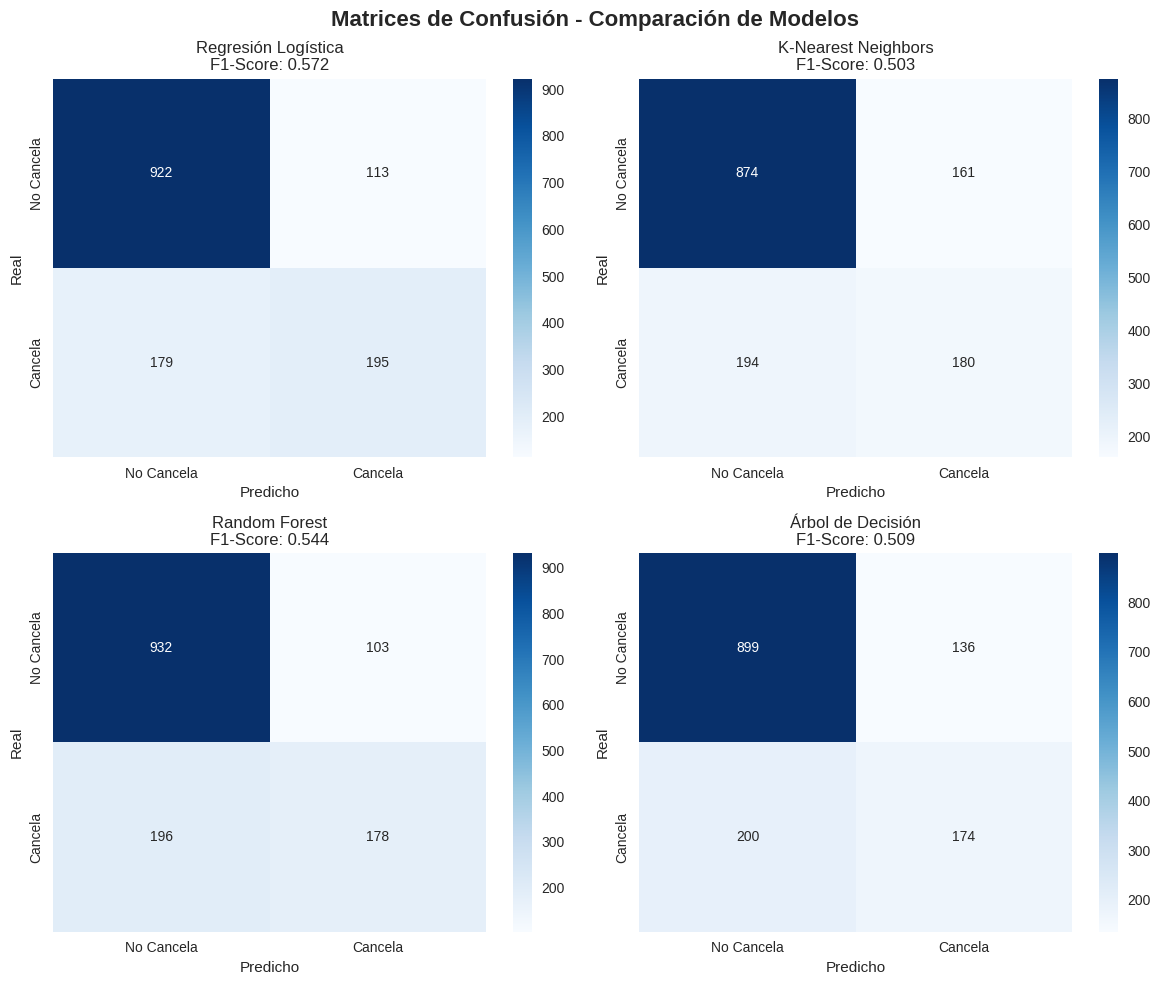

In [96]:
evaluacion_resultados = ejecutar_evaluacion_completa(resultados_ml)


In [97]:
print(evaluacion_resultados['recomendacion_final'])

{'modelo': 'Regresión Logística', 'metricas': {'Modelo': 'Regresión Logística', 'Normalizado': '✅', 'Exactitud': 0.7927608232789212, 'Precisión': 0.6331168831168831, 'Recall': 0.5213903743315508, 'F1-Score': 0.5718475073313783, 'ROC-AUC': 0.8431256296985198, 'Overfitting': '✅', 'Underfitting': '⚠️'}, 'razon': 'mejor balance entre precisión y recall (requiere optimización adicional)'}


In [98]:
print(evaluacion_resultados['tabla_comparativa'])


                Modelo Normalizado  Exactitud  Precisión    Recall  F1-Score  \
0  Regresión Logística           ✅   0.792761   0.633117  0.521390  0.571848   
1  K-Nearest Neighbors           ✅   0.748048   0.527859  0.481283  0.503497   
2        Random Forest           ❌   0.787793   0.633452  0.475936  0.543511   
3    Árbol de Decisión           ❌   0.761533   0.561290  0.465241  0.508772   

    ROC-AUC Overfitting Underfitting  
0  0.843126           ✅           ⚠️  
1  0.775181          ⚠️           ⚠️  
2  0.823354          ⚠️           ⚠️  
3  0.746722          ⚠️           ⚠️  


In [99]:
modelo_rf = evaluacion_resultados['evaluaciones_individuales']['random_forest']
print(f"Random Forest F1-Score: {modelo_rf['metricas_test']['f1_score']:.3f}")

Random Forest F1-Score: 0.544


# **ANÁLISIS DE IMPORTANCIA DE VARIABLES - TELECOM X CHALLENGE**

In [100]:

# REGRESIÓN LOGÍSTICA - ANÁLISIS DE COEFICIENTES
# =============================================================================

def analizar_coeficientes_logistic(modelo_info, feature_names, top_n=15):
    """
    Analiza coeficientes de Regresión Logística para identificar variables más influyentes.

    Args:
        modelo_info: Dict con modelo entrenado de regresión logística
        feature_names: Lista de nombres de variables
        top_n: Número de variables más importantes a mostrar

    Returns:
        dict: Análisis de coeficientes
    """

    print("📊 REGRESIÓN LOGÍSTICA - ANÁLISIS DE COEFICIENTES")
    print("=" * 60)

    modelo = modelo_info['modelo']
    coeficientes = modelo.coef_[0]

    # Crear DataFrame con coeficientes
    coef_df = pd.DataFrame({
        'Variable': feature_names,
        'Coeficiente': coeficientes,
        'Abs_Coeficiente': np.abs(coeficientes),
        'Odds_Ratio': np.exp(coeficientes),
        'Efecto': ['Aumenta Churn' if c > 0 else 'Reduce Churn' for c in coeficientes]
    })

    # Ordenar por importancia absoluta
    coef_df = coef_df.sort_values('Abs_Coeficiente', ascending=False)

    print(f"🎯 TOP {top_n} VARIABLES MÁS INFLUYENTES:")
    print("-" * 60)
    print(f"{'Variable':<25} {'Coef':<8} {'Odds Ratio':<10} {'Efecto':<15}")
    print("-" * 60)

    for idx, row in coef_df.head(top_n).iterrows():
        var_name = row['Variable'][:24]
        coef = row['Coeficiente']
        odds = row['Odds_Ratio']
        efecto = row['Efecto']
        print(f"{var_name:<25} {coef:7.3f} {odds:9.3f} {efecto:<15}")

    # Interpretación de coeficientes más importantes
    print(f"\n💡 INTERPRETACIÓN COEFICIENTES:")
    print("-" * 40)

    top_positivo = coef_df[coef_df['Coeficiente'] > 0].head(3)
    top_negativo = coef_df[coef_df['Coeficiente'] < 0].head(3)

    if not top_positivo.empty:
        print("🔴 Variables que MÁS AUMENTAN probabilidad de churn:")
        for idx, row in top_positivo.iterrows():
            odds_interpretation = ((row['Odds_Ratio'] - 1) * 100)
            print(f"   • {row['Variable'][:30]}: +{odds_interpretation:.1f}% probabilidad")

    if not top_negativo.empty:
        print("🟢 Variables que MÁS REDUCEN probabilidad de churn:")
        for idx, row in top_negativo.iterrows():
            odds_interpretation = ((1 - row['Odds_Ratio']) * 100)
            print(f"   • {row['Variable'][:30]}: -{odds_interpretation:.1f}% probabilidad")

    return {
        'coeficientes_df': coef_df,
        'top_aumentan_churn': top_positivo.head(5),
        'top_reducen_churn': top_negativo.head(5),
        'interpretacion': 'coeficientes_lineales'
    }

# =============================================================================
# K-NEAREST NEIGHBORS - ANÁLISIS DE PROXIMIDAD
# =============================================================================

def analizar_proximidad_knn(modelo_info, X_test_scaled, y_test, feature_names, n_samples=100):
    """
    Analiza influencia de variables en KNN mediante proximidad y permutación.
    """

    print("\n📊 K-NEAREST NEIGHBORS - ANÁLISIS DE PROXIMIDAD")
    print("=" * 60)

    modelo = modelo_info['modelo']
    # X_test_data = modelo_info['X_test'] # Esto ya viene escalado

    # Análisis de permutación (más confiable para KNN)
    print("🔍 Calculando importancia por permutación...")

    # Usar subset para eficiencia
    n_samples_actual = min(n_samples, len(X_test_scaled))
    indices_muestra = np.random.choice(len(X_test_scaled), n_samples_actual, replace=False)
    X_sample_scaled = X_test_scaled.iloc[indices_muestra]
    y_sample = y_test.iloc[indices_muestra]

    # Permutation importance
    perm_importance = permutation_importance(
        modelo, X_sample_scaled, y_sample, n_repeats=10, random_state=42, scoring='f1'
    )

    # Crear DataFrame con importancias
    importancia_df = pd.DataFrame({
        'Variable': feature_names,
        'Importancia_Media': perm_importance.importances_mean,
        'Importancia_Std': perm_importance.importances_std
    }).sort_values('Importancia_Media', ascending=False)

    print(f"\n🎯 TOP 15 VARIABLES MÁS INFLUYENTES (por permutación):")
    print("-" * 60)
    print(f"{'Variable':<30} {'Importancia':<12} {'Std':<8}")
    print("-" * 60)

    for idx, row in importancia_df.head(15).iterrows():
        var_name = row['Variable'][:29]
        imp = row['Importancia_Media']
        std = row['Importancia_Std']
        print(f"{var_name:<30} {imp:11.4f} {std:7.4f}")

    # Análisis de vecinos para casos específicos
    print(f"\n🔍 ANÁLISIS DE VECINOS CERCANOS:")
    print("-" * 40)

    # Buscar algunos casos de churn y no-churn para analizar vecinos
    # Asegurarse de que los índices existan en X_sample_scaled y y_sample
    churn_indices_sample = y_sample[y_sample == True].index[:2]
    no_churn_indices_sample = y_sample[y_sample == False].index[:2]

    indices_analisis = list(churn_indices_sample) + list(no_churn_indices_sample)

    # Asegurarse de que hay suficientes casos para analizar
    if not indices_analisis:
        print("   No hay suficientes casos de ejemplo en la muestra para analizar vecinos.")
    else:
        for i, idx in enumerate(indices_analisis):
            # Obtener el caso escalado para el análisis de vecinos
            caso_actual_scaled = X_sample_scaled.loc[idx:idx]
            etiqueta_actual = y_sample.loc[idx]

            # Encontrar vecinos en el conjunto de entrenamiento escalado
            # Es más relevante ver vecinos en el conjunto de entrenamiento, no en la muestra de test
            # Usaremos el X_train escalado del modelo_info
            X_train_scaled_knn = modelo_info['X_train']
            y_train_knn = resultados_ml['division_datos']['y_train'] # Necesitamos las etiquetas del train set

            # Entrenar un NearestNeighbors solo para encontrar vecinos
            nn = NearestNeighbors(n_neighbors=modelo.n_neighbors)
            nn.fit(X_train_scaled_knn)

            distancias, vecinos_idx_train = nn.kneighbors(caso_actual_scaled)

            # Obtener las etiquetas de los vecinos encontrados en el conjunto de entrenamiento
            vecinos_labels = y_train_knn.iloc[vecinos_idx_train[0]]

            tipo_caso = "Churn" if etiqueta_actual else "No-Churn"
            vecinos_churn_count = vecinos_labels.sum() # Contar cuántos vecinos son churn

            print(f"   Caso {i+1} ({tipo_caso}): {vecinos_churn_count}/{modelo.n_neighbors} vecinos (en train) son churn")


    return {
        'importancia_df': importancia_df,
        'metodo': 'permutation_importance',
        'interpretacion': 'impacto_en_f1_cuando_se_permuta' # Cambiar interpretación a F1
    }

# =============================================================================
# RANDOM FOREST - IMPORTANCIA DE VARIABLES
# =============================================================================

def analizar_importancia_random_forest(modelo_info, feature_names, top_n=15):
    """
    Analiza importancia de variables en Random Forest.
    """

    print("\n📊 RANDOM FOREST - IMPORTANCIA DE VARIABLES")
    print("=" * 60)

    modelo = modelo_info['modelo']

    # Obtener importancias del modelo
    importancias = modelo.feature_importances_

    # Crear DataFrame
    importancia_df = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias,
        'Importancia_Pct': importancias / importancias.sum() * 100
    }).sort_values('Importancia', ascending=False)

    print(f"🎯 TOP {top_n} VARIABLES MÁS IMPORTANTES:")
    print("-" * 50)
    print(f"{'Variable':<30} {'Importancia':<12} {'%':<8}")
    print("-" * 50)

    for idx, row in importancia_df.head(top_n).iterrows():
        var_name = row['Variable'][:29]
        imp = row['Importancia']
        pct = row['Importancia_Pct']
        print(f"{var_name:<30} {imp:11.4f} {pct:7.2f}%")

    # Estadísticas adicionales
    top_5_sum = importancia_df.head(5)['Importancia_Pct'].sum()
    top_10_sum = importancia_df.head(10)['Importancia_Pct'].sum()

    print(f"\n📈 CONCENTRACIÓN DE IMPORTANCIA:")
    print(f"   • Top 5 variables explican: {top_5_sum:.1f}% del modelo")
    print(f"   • Top 10 variables explican: {top_10_sum:.1f}% del modelo")

    # Análisis por categorías de variables
    print(f"\n🔍 ANÁLISIS POR TIPO DE VARIABLE:")
    print("-" * 40)

    # Categorizar variables
    variables_numericas = [v for v in feature_names if any(x in v for x in ['Cargos', 'Antiguedad', 'Meses'])]
    variables_contrato = [v for v in feature_names if 'Contrato' in v]
    variables_servicios = [v for v in feature_names if any(x in v for x in ['Streaming', 'Seguridad', 'Respaldo', 'Proteccion', 'Soporte'])]
    variables_demograficas = [v for v in feature_names if any(x in v for x in ['Genero', 'Adulto', 'Pareja', 'Dependientes'])]

    categorias = {
        'Numéricas (Cargos/Tiempo)': variables_numericas,
        'Tipo de Contrato': variables_contrato,
        'Servicios Adicionales': variables_servicios,
        'Demográficas': variables_demograficas
    }

    for categoria, variables in categorias.items():
        if variables:
            importancia_categoria = importancia_df[importancia_df['Variable'].isin(variables)]['Importancia_Pct'].sum()
            print(f"   • {categoria:<25}: {importancia_categoria:5.1f}%")

    return {
        'importancia_df': importancia_df,
        'concentracion': {
            'top_5': top_5_sum,
            'top_10': top_10_sum
        },
        'por_categoria': {cat: importancia_df[importancia_df['Variable'].isin(vars)]['Importancia_Pct'].sum()
                         for cat, vars in categorias.items() if vars},
        'interpretacion': 'reduccion_impureza_gini'
    }

# =============================================================================
# ÁRBOL DE DECISIÓN - ANÁLISIS DE SPLITS
# =============================================================================

def analizar_decision_tree(modelo_info, feature_names, max_depth=5):
    """
    Analiza importancia en Árbol de Decisión y principales divisiones.
    """

    print("\n📊 ÁRBOL DE DECISIÓN - ANÁLISIS DE SPLITS")
    print("=" * 60)

    modelo = modelo_info['modelo']

    # Importancia de variables
    importancias = modelo.feature_importances_

    importancia_df = pd.DataFrame({
        'Variable': feature_names,
        'Importancia': importancias,
        'Importancia_Pct': importancias / importancias.sum() * 100
    }).sort_values('Importancia', ascending=False)

    print("🎯 TOP 10 VARIABLES MÁS IMPORTANTES:")
    print("-" * 50)
    print(f"{'Variable':<30} {'Importancia':<12} {'%':<8}")
    print("-" * 50)

    for idx, row in importancia_df.head(10).iterrows():
        var_name = row['Variable'][:29]
        imp = row['Importancia']
        pct = row['Importancia_Pct']
        print(f"{var_name:<30} {imp:11.4f} {pct:7.2f}%")

    # Información del árbol
    print(f"\n🌳 INFORMACIÓN DEL ÁRBOL:")
    print(f"   • Profundidad máxima: {modelo.get_depth()}")
    print(f"   • Número de hojas: {modelo.get_n_leaves()}")
    print(f"   • Número de nodos: {modelo.tree_.node_count}")

    # Analizar primeros splits (más importantes)
    tree = modelo.tree_
    feature_names_array = np.array(feature_names)

    print(f"\n🔍 PRINCIPALES DIVISIONES (SPLITS):")
    print("-" * 45)

    def obtener_splits_importantes(node_id=0, depth=0, max_depth=3):
        if depth >= max_depth or tree.children_left[node_id] == tree.children_right[node_id]:
            return

        feature_idx = tree.feature[node_id]
        threshold = tree.threshold[node_id]
        feature_name = feature_names_array[feature_idx]
        impurity_reduction = tree.impurity[node_id]

        indent = "  " * depth
        print(f"{indent}Split {depth+1}: {feature_name[:25]} <= {threshold:.3f} (impureza: {impurity_reduction:.3f})")

        # Continuar con hijos
        obtener_splits_importantes(tree.children_left[node_id], depth+1, max_depth)
        obtener_splits_importantes(tree.children_right[node_id], depth+1, max_depth)

    obtener_splits_importantes()

    return {
        'importancia_df': importancia_df,
        'info_arbol': {
            'profundidad': modelo.get_depth(),
            'hojas': modelo.get_n_leaves(),
            'nodos': modelo.tree_.node_count
        },
        'interpretacion': 'reduccion_impureza_en_splits'
    }

# =============================================================================
# FUNCIÓN PRINCIPAL - ANÁLISIS COMPLETO DE IMPORTANCIA
# =============================================================================

def analizar_importancia_variables_completo(resultados_ml):
    """
    Ejecuta análisis completo de importancia de variables para todos los modelos.

    Args:
        resultados_ml: Resultado de ejecutar_division_y_modelado()

    Returns:
        dict: Análisis de importancia para cada modelo
    """

    print("🎯" * 25)
    print("🔬 ANÁLISIS DE IMPORTANCIA DE VARIABLES - TELECOM X CHALLENGE")
    print("🎯" * 25)

    # Extraer datos necesarios
    modelos = resultados_ml['modelos_entrenados']['modelos']
    X_test = resultados_ml['division_datos']['X_test'] # Original X_test for feature names
    y_test = resultados_ml['division_datos']['y_test']
    feature_names = list(X_test.columns)

    # Get scaled test data for models that require it
    X_test_scaled = resultados_ml['modelos_entrenados']['datos_normalizados']['X_test']


    print(f"\n📋 CONFIGURACIÓN:")
    print(f"   • Total de variables: {len(feature_names)}")
    print(f"   • Modelos a analizar: {len(modelos)}")

    analisis_completo = {}

    # Analizar cada modelo
    for modelo_key, modelo_info in modelos.items():
        nombre_modelo = modelo_info['nombre']
        print(f"\n⏳ Analizando {nombre_modelo}...")

        if 'logistic' in modelo_key.lower():
            # Logistic Regression uses scaled data, but we analyze coefficients
            # based on the feature names from the original data
            analisis = analizar_coeficientes_logistic(modelo_info, feature_names)

        elif 'knn' in modelo_key.lower():
            # KNN analysis needs the scaled test data
            analisis = analizar_proximidad_knn(modelo_info, X_test_scaled, y_test, feature_names)

        elif 'random_forest' in modelo_key.lower():
            # Random Forest uses original data
            analisis = analizar_importancia_random_forest(modelo_info, feature_names)

        elif 'decision_tree' in modelo_key.lower():
            # Decision Tree uses original data
            analisis = analizar_decision_tree(modelo_info, feature_names)

        else:
            print(f"   ⚠️ Tipo de modelo no reconocido: {nombre_modelo}")
            continue

        analisis['modelo'] = nombre_modelo
        analisis_completo[modelo_key] = analisis

    # Comparación entre modelos
    print(f"\n{'='*80}")
    print("📊 COMPARACIÓN DE VARIABLES MÁS IMPORTANTES ENTRE MODELOS")
    print(f"{'='*80}")

    # Extraer top 5 variables de cada modelo
    top_variables_por_modelo = {}

    for modelo_key, analisis in analisis_completo.items():
        if 'importancia_df' in analisis:
            top_5 = list(analisis['importancia_df'].head(5)['Variable'])
        elif 'coeficientes_df' in analisis:
            top_5 = list(analisis['coeficientes_df'].head(5)['Variable'])
        else:
            continue

        top_variables_por_modelo[analisis['modelo']] = top_5

    # Mostrar comparación
    if top_variables_por_modelo:
        max_length = max(len(modelo) for modelo in top_variables_por_modelo.keys())

        print(f"🏆 TOP 5 VARIABLES POR MODELO:")
        print("-" * 80)

        for modelo, variables in top_variables_por_modelo.items():
            print(f"{modelo:<20}:")
            for i, var in enumerate(variables, 1):
                print(f"   {i}. {var[:50]}")
            print()

    # Variables que aparecen en múltiples modelos
    print(f"🔄 VARIABLES CONSISTENTEMENTE IMPORTANTES:")
    print("-" * 50)

    todas_las_variables = []
    for variables in top_variables_por_modelo.values():
        todas_las_variables.extend(variables)

    from collections import Counter
    contador_variables = Counter(todas_las_variables)
    variables_frecuentes = [(var, count) for var, count in contador_variables.items() if count > 1]
    variables_frecuentes.sort(key=lambda x: x[1], reverse=True)

    if variables_frecuentes:
        print("Variables que aparecen en múltiples modelos:")
        for var, count in variables_frecuentes:
            print(f"   • {var[:45]}: {count} modelos")
    else:
        print("No hay variables que aparezcan consistentemente en múltiples modelos")

    # Recomendaciones finales
    print(f"\n💡 INSIGHTS PARA TELECOM X:")
    print("-" * 40)

    if variables_frecuentes:
        var_mas_importante = variables_frecuentes[0][0]
        print(f"✅ Variable más consistente: {var_mas_importante}")

    print(f"✅ Cada modelo ofrece perspectivas diferentes:")
    print(f"   • Regresión Logística: Relaciones lineales directas")
    print(f"   • Random Forest: Interacciones no lineales complejas")
    print(f"   • KNN: Patrones de proximidad en el espacio de características")
    print(f"   • Árbol Decisión: Reglas de negocio interpretables")

    return {
        'analisis_por_modelo': analisis_completo,
        'comparacion_top_variables': top_variables_por_modelo,
        'variables_consistentes': variables_frecuentes,
        'feature_names': feature_names
    }

# =============================================================================
# VISUALIZACIÓN DE IMPORTANCIAS
# =============================================================================

def visualizar_importancias(analisis_importancia):
    """
    Crea visualizaciones de importancia de variables.
    """

    analisis_por_modelo = analisis_importancia['analisis_por_modelo']

    # Determinar número de subplots necesarios
    modelos_con_importancia = [m for m in analisis_por_modelo.values()
                              if 'importancia_df' in m or 'coeficientes_df' in m]

    if not modelos_con_importancia:
        print("No hay datos de importancia para visualizar")
        return

    n_modelos = len(modelos_con_importancia)
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    axes = axes.ravel()

    plt.suptitle('Importancia de Variables por Modelo', fontsize=16, fontweight='bold')

    for i, analisis in enumerate(modelos_con_importancia[:4]):
        if 'importancia_df' in analisis:
            df = analisis['importancia_df'].head(10)
            x_col = 'Importancia'
        elif 'coeficientes_df' in analisis:
            df = analisis['coeficientes_df'].head(10)
            x_col = 'Abs_Coeficiente'
        else:
            continue

        # Crear barplot
        y_pos = range(len(df))
        axes[i].barh(y_pos, df[x_col], alpha=0.7)
        axes[i].set_yticks(y_pos)
        axes[i].set_yticklabels([var[:20] for var in df['Variable']], fontsize=8)
        axes[i].set_xlabel(x_col)
        axes[i].set_title(f"{analisis['modelo']}")
        axes[i].invert_yaxis()

    # Ocultar subplots vacíos
    for j in range(i+1, 4):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# =============================================================================
# FUNCIÓN DE EJECUCIÓN PRINCIPAL
# =============================================================================

def ejecutar_analisis_importancia_completo(resultados_ml):
    """
    Ejecuta análisis completo de importancia de variables.

    Args:
        resultados_ml: Resultado de ejecutar_division_y_modelado()

    Returns:
        dict: Análisis completo de importancia de variables
    """

    print("🚀 INICIANDO ANÁLISIS DE IMPORTANCIA DE VARIABLES")
    print("=" * 80)

    if resultados_ml is None:
        print("❌ Error: No se proporcionaron resultados de modelado válidos")
        return None

    # Realizar análisis completo
    analisis_importancia = analizar_importancia_variables_completo(resultados_ml)

    # Generar visualizaciones
    try:
        print(f"\n📈 Generando visualizaciones de importancia...")
        visualizar_importancias(analisis_importancia)
    except Exception as e:
        print(f"⚠️ No se pudieron generar visualizaciones: {e}")

    print(f"\n🎉 ANÁLISIS DE IMPORTANCIA COMPLETADO!")
    print("=" * 80)
    print("📊 Resultados disponibles:")
    print("   • analisis_importancia['analisis_por_modelo'] - Detalles por modelo")
    print("   • analisis_importancia['variables_consistentes'] - Variables importantes en múltiples modelos")
    print("   • analisis_importancia['comparacion_top_variables'] - Top 5 por modelo")

    return analisis_importancia

# =============================================================================
# INSTRUCCIONES DE USO
# =============================================================================

print("\n" + "📋" * 25)
print("INSTRUCCIONES PARA ANÁLISIS DE IMPORTANCIA:")
print("📋" * 25)
print("""
# Ejecutar análisis completo de importancia:
analisis_importancia = ejecutar_analisis_importancia_completo(resultados_ml)

# Ver variables más importantes de Random Forest:
rf_importancia = analisis_importancia['analisis_por_modelo']['random_forest']['importancia_df']
print(rf_importancia.head())

# Ver coeficientes de Regresión Logística:
lr_coef = analisis_importancia['analisis_por_modelo']['logistic_regression']['coeficientes_df']
print(lr_coef.head())

# Ver variables consistentes entre modelos:
print(analisis_importancia['variables_consistentes'])
""")

print("\n✅ ANÁLISIS DE IMPORTANCIA DE VARIABLES COMPLETADO")
print("🎯 Incluye interpretaciones específicas para cada tipo de modelo")
print("🚀 Ejecuta: analisis_importancia = ejecutar_analisis_importancia_completo(resultados_ml)")


📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋
INSTRUCCIONES PARA ANÁLISIS DE IMPORTANCIA:
📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋📋

# Ejecutar análisis completo de importancia:
analisis_importancia = ejecutar_analisis_importancia_completo(resultados_ml)

# Ver variables más importantes de Random Forest:
rf_importancia = analisis_importancia['analisis_por_modelo']['random_forest']['importancia_df']
print(rf_importancia.head())

# Ver coeficientes de Regresión Logística:
lr_coef = analisis_importancia['analisis_por_modelo']['logistic_regression']['coeficientes_df']
print(lr_coef.head())

# Ver variables consistentes entre modelos:
print(analisis_importancia['variables_consistentes'])


✅ ANÁLISIS DE IMPORTANCIA DE VARIABLES COMPLETADO
🎯 Incluye interpretaciones específicas para cada tipo de modelo
🚀 Ejecuta: analisis_importancia = ejecutar_analisis_importancia_completo(resultados_ml)


🚀 INICIANDO ANÁLISIS DE IMPORTANCIA DE VARIABLES
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯
🔬 ANÁLISIS DE IMPORTANCIA DE VARIABLES - TELECOM X CHALLENGE
🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯🎯

📋 CONFIGURACIÓN:
   • Total de variables: 24
   • Modelos a analizar: 4

⏳ Analizando Regresión Logística...
📊 REGRESIÓN LOGÍSTICA - ANÁLISIS DE COEFICIENTES
🎯 TOP 15 VARIABLES MÁS INFLUYENTES:
------------------------------------------------------------
Variable                  Coef     Odds Ratio Efecto         
------------------------------------------------------------
AntigüedadMeses            -1.407     0.245 Reduce Churn   
CargosTotales               0.677     1.968 Aumenta Churn  
TipoContrato_Two year      -0.584     0.558 Reduce Churn   
TipoInternet_Fiber optic    0.569     1.766 Aumenta Churn  
TipoInternet_No            -0.513     0.599 Reduce Churn   
TipoContrato_One year      -0.280     0.756 Reduce Churn   
CargosMensuales            -0.268     0.765 Reduce Churn   
CargosDiarios              -0.258     0

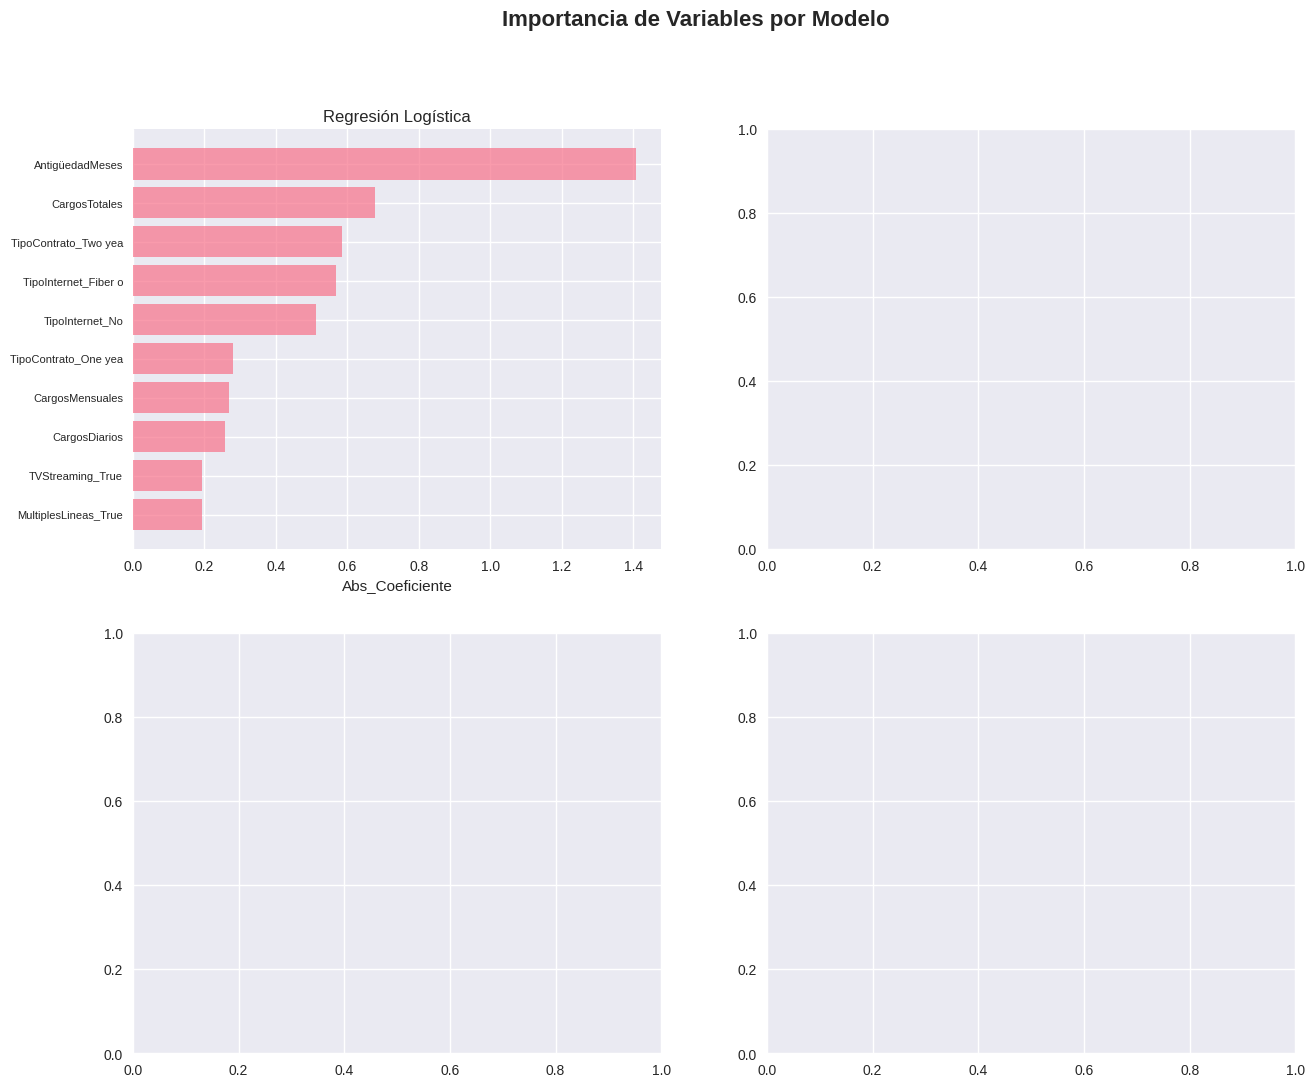

In [101]:
# Después de tener evaluación completa:
analisis_importancia = ejecutar_analisis_importancia_completo(resultados_ml)

In [102]:
rf_importancia = analisis_importancia['analisis_por_modelo']['random_forest']['importancia_df']
print(rf_importancia.head())

                    Variable  Importancia  Importancia_Pct
7              CargosTotales     0.176411        17.641085
3            AntigüedadMeses     0.153241        15.324139
6            CargosMensuales     0.138243        13.824323
8              CargosDiarios     0.120278        12.027830
11  TipoInternet_Fiber optic     0.041039         4.103911


In [103]:
lr_coef = analisis_importancia['analisis_por_modelo']['logistic_regression']['coeficientes_df']
print(lr_coef.head())

                    Variable  Coeficiente  Abs_Coeficiente  Odds_Ratio  \
3            AntigüedadMeses    -1.407491         1.407491    0.244757   
7              CargosTotales     0.677114         0.677114    1.968189   
20     TipoContrato_Two year    -0.583937         0.583937    0.557698   
11  TipoInternet_Fiber optic     0.568753         0.568753    1.766064   
12           TipoInternet_No    -0.512945         0.512945    0.598730   

           Efecto  
3    Reduce Churn  
7   Aumenta Churn  
20   Reduce Churn  
11  Aumenta Churn  
12   Reduce Churn  


In [104]:
print(analisis_importancia['variables_consistentes'])


[('AntigüedadMeses', 3), ('CargosTotales', 3), ('TipoInternet_Fiber optic', 3), ('CargosMensuales', 2), ('CargosDiarios', 2)]
